# Age Estimation task

## Imports

In [79]:
import numpy as np
import pandas as pd
import scipy
from scipy.io import wavfile
from scipy.stats import skew, kurtosis

# for regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import statistics

import seaborn as sns

# for audio processing
import os
import librosa
import librosa.display
import librosa.feature
import noisereduce as nr
import parselmouth as pm
import maad as maad
from maad import features
import parselmouth
from parselmouth.praat import call

from joblib import Parallel, delayed
from tqdm import tqdm

# for layout
from prettytable import PrettyTable
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
warnings.filterwarnings("ignore")

# %matplotlib widget

## Constants

In [441]:
FILE_DEVELOPMENT = "Dataset/development.csv"
FILE_EVALUATION = "Dataset/evaluation.csv"
AUDIOS_DEVELOPMENT = "Dataset/audios_development/"
AUDIOS_EVALUATION = "Dataset/audios_evaluation/"

AUDIOS_DEVELOPMENT_CLEANED = "Dataset/audios_development_cleaned/"
AUDIOS_EVALUATION_CLEANED = "Dataset/audios_evaluation_cleaned/"

COMPUTE_ALL = False

N_MFCC = 35
FREQ_BIN = 32

precisionLog = {
    'mean_pitch':2, 
    'max_pitch':2, 
    'min_pitch':3, 
    'jitter':2, 
    'shimmer':2, 
    'energy':1, 
    'zcr_mean':2, 
    'spectral_centroid_mean':2,
    'tempo':3,
    'hnr':0
}

precisionLinear = {
    'mean_pitch':-1, 
    'max_pitch':-2, 
    'min_pitch':0, 
    'jitter':3, 
    'shimmer':3, 
    'energy':3, 
    'zcr_mean':2, 
    'spectral_centroid_mean':-2,
    'tempo':3,
    'hnr':0
}

columns_correlator = {
    k:v for k,v in zip(
        [
            "time_domain.csv", 
            "freq_domain.csv", 
            "spectrogram.csv", 
            "mel_spectrogram.csv", 
            "mfcc.csv", 
            "hpss.csv", 
            "zcr.csv", 
            "poly.csv", 
            "formants.csv",
            "temporal_median.csv",
            "entropy.csv"
        ], 
        [
            ['audio_length','mean_absolute_slope','pitch_iqr','voiced_frames','number_of_frames','sm','sv','ss','sk','Time 5%','Time 25%','Time 50%','Time 75%','Time 95%','duration_50','duration_90'], 
            ['dominant_frequency'], 
            ['spect_overall_mean'] + [f"spect_frequency_mean_{t}" for t in range(FREQ_BIN)],
            ['mel_overall_mean'] + [f"mel_frequency_mean_{t}" for t in range(FREQ_BIN)],
            [f"mfcc_frequency_mean_{t}" for t in range(N_MFCC)],
            ['harmonic_overall_mean', 'harmonic_overall_var', 'percussion_overall_mean', 'percussion_overall_var'] + [f"harmonic_frequency_mean_{t}" for t in range(FREQ_BIN)] + [f"harmonic_frequency_var_{t}" for t in range(FREQ_BIN)] + [f"percussion_frequency_mean_{t}" for t in range(FREQ_BIN)] + [f"percussion_frequency_var_{t}" for t in range(FREQ_BIN)],
            ['zcr'],
            ['mean_coeffs', 'std_coeffs'],
            ['f0_mean','f1_mean','f2_mean','f3_mean','f4_mean','f0_var','f1_var','f2_var','f3_var','f4_var'],
            ['temporalMedian'],
            ['temporal_entropy', 'frequence_entropy','mean_spectral_entropy']
        ]
    )
}

## Data reading

In [81]:
dev_original_df = pd.read_csv(FILE_DEVELOPMENT, header=0, index_col=0)
eval_original_df = pd.read_csv(FILE_EVALUATION, header=0, index_col=0)

audio_dev = os.listdir(AUDIOS_DEVELOPMENT)
audio_eval = os.listdir(AUDIOS_EVALUATION)

print(audio_dev[:5])
print(audio_eval[:5])

['1.wav', '10.wav', '100.wav', '1000.wav', '1001.wav']
['1.wav', '10.wav', '100.wav', '101.wav', '102.wav']


Order audios by integers and increasing order

In [82]:
audio_dev.sort(key=lambda x: int(x.split('.')[0]))
audio_eval.sort(key=lambda x: int(x.split('.')[0]))

print(audio_dev[:5])
print(audio_eval[:5])

['1.wav', '2.wav', '3.wav', '4.wav', '5.wav']
['1.wav', '2.wav', '3.wav', '4.wav', '5.wav']


## Tabular Data Exploration

In [83]:
# display(dev_original_df.head())

display(f"Total number of nan in development: {dev_original_df.isna().sum().sum()}")
display(f"Total number of nan in evaluation: {eval_original_df.isna().sum().sum()}")

desc_dev_df = dev_original_df.describe()
desc_eval_df = eval_original_df.describe()

sampling_rate = dev_original_df['sampling_rate'].iloc[0]

display(desc_dev_df.loc['std', 'sampling_rate'])
display(desc_eval_df.loc['std', 'sampling_rate'])

dev_df = dev_original_df.drop('sampling_rate', axis=1)
eval_df = eval_original_df.drop('sampling_rate', axis=1)

ages_df = dev_df[['age']]
path_dev_df = dev_df[['path']]
path_eval_df = eval_df[['path']]

dev_df = dev_df.drop(['path'], axis=1)
eval_df = eval_df.drop('path', axis=1)

display(dev_df.head())
display(eval_df.head())

'Total number of nan in development: 0'

'Total number of nan in evaluation: 0'

np.float64(0.0)

np.float64(0.0)

,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,,
0,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,[151.99908088],-123.999726,69,281,39,23.846893
1,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,[129.19921875],-86.928478,69,281,21,19.388662
2,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,[117.45383523],-98.450670,69,281,1,21.640998
3,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,[117.45383523],-56.459762,69,281,9,19.644127
4,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,[112.34714674],-80.349204,69,281,11,18.041905


,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,
0,male,spanish,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,[80.74951172],-116.662338,69,281,2,38.198503
1,male,xiang,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,[89.10290948],-78.253824,69,281,27,29.605442
2,male,igbo,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,[123.046875],-71.630742,6,22,2,2.275556
3,female,spanish,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,[123.046875],-101.533013,69,281,31,22.151837
4,male,spanish,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,[112.34714674],-134.914070,69,281,35,22.430476


In [84]:
et = dev_df['ethnicity'].value_counts()
et

ethnicity
igbo        1081
english      579
arabic       102
mandarin      65
french        63
            ... 
hakka          1
malagasy       1
lingala        1
fang           1
rundi          1
Name: count, Length: 165, dtype: int64

## Preprocess tabular data

### Encoding

#### Ethnicity

In [85]:
def encode_english(X_df:pd.DataFrame):
    X_copy = X_df.copy()

    X_copy['english'] = (X_copy['ethnicity'] == 'english').astype(int)
    X_copy['others'] = (X_copy['ethnicity'] != 'english').astype(int)

    return X_copy.drop(columns='ethnicity', axis=1)

In [86]:
def encode_ethnicity(X_df, ethnie):
    aggregated_ethnicity_df = X_df.copy()

    # etna = pd.DataFrame(1, columns=ethnie, index=X_df.index, dtype=float)

    # aggregated_ethnicity_df.loc[~(aggregated_ethnicity_df['ethnicity'].isin(ethnie)), 'ethnicity'] = 'others'

    # for etnia in ethnie:
    #     aggregated_ethnicity_df.loc[aggregated_ethnicity_df['ethnicity'] == etnia, etnia] = etna[etnia]

    #     # aggregated_ethnicity_df.loc[aggregated_ethnicity_df['ethnicity'] == etnia, etnia] = 1
    #     aggregated_ethnicity_df.loc[~(aggregated_ethnicity_df['ethnicity'] == etnia), etnia] = 0

    # # encoded_ethnicity = pd.get_dummies(aggregated_ethnicity_df['ethnicity'], dtype=int)

    try:
        aggregated_ethnicity_df = aggregated_ethnicity_df.drop(columns=['ethnicity'], axis=1)
    except KeyError:
        pass

    return aggregated_ethnicity_df

In [87]:
enticity_df = dev_df['ethnicity'].value_counts().sort_values(ascending=False)

median_et = enticity_df.median()
display(enticity_df[enticity_df == 1].shape)
display(enticity_df.head(20))
display(enticity_df.tail(10))
# enticity_df[enticity_df > median_et].plot()

# etnie_chosen = sorted(list(set(enticity_df[enticity_df > median_et].index))) + ['others']
etnie_chosen = ['english','igbo']
display(etnie_chosen)
display(etnie_chosen.__len__())

(58,)

ethnicity
igbo          1081
english        579
arabic         102
mandarin        65
french          63
korean          52
portuguese      48
russian         48
dutch           47
german          36
polish          34
italian         33
urhobo          32
japanese        27
ibibio          27
macedonian      26
farsi           23
cantonese       23
igala           22
amharic         20
Name: count, dtype: int64

ethnicity
faroese        1
nandi          1
nuer           1
dinka          1
mortlockese    1
hakka          1
malagasy       1
lingala        1
fang           1
rundi          1
Name: count, dtype: int64

['english', 'igbo']

2

#### Gender

In [88]:
def encode_gender_one_hot(X_df:pd.DataFrame):
    X_copy = X_df.copy()

    X_copy['male'] = (X_copy['gender'] == 'male').astype(int)
    X_copy['female'] = (X_copy['gender'].isin(['female','famale'])).astype(int)

    return X_copy.drop(columns='gender', axis=1)

In [89]:
GenderMapper = {
    'male': 1,
    'female': -1
}

def encode_gender(X_df:pd.DataFrame, mapper):
    encoded_df = X_df.copy()
    for gender, value in mapper.items():
        encoded_df.loc[encoded_df['gender'] == gender, 'gender'] = value

    encoded_df.loc[encoded_df['gender'] == 'famale', 'gender'] = GenderMapper['female']

    encoded_df['gender'] = encoded_df['gender'].astype(float)
    return encoded_df

#### Tempo

In [90]:
# display(encoded_gender_etnicity_df['tempo'])

def encode_tempo(X_df):
    encoded_df = X_df.copy()
    encoded_df['tempo'] = encoded_df['tempo'].map(lambda x: float(x.strip('[').strip(']')))
    return encoded_df


#### Results

In [91]:
display(eval_df.loc[eval_df['ethnicity'].isin(etnie_chosen), 'ethnicity'].value_counts())

# FOR NOW, WE WILL DROP ETHNICITY #TODO:

# step1_dev_df = dev_df.drop(columns='ethnicity', axis=1)
# step1_eval_df = eval_df.drop(columns='ethnicity', axis=1)

# step1_dev_df = encode_english(dev_df)
# step1_eval_df = encode_english(eval_df)

step1_dev_df = encode_ethnicity(dev_df, etnie_chosen)
step1_eval_df = encode_ethnicity(eval_df, etnie_chosen)

# step2_dev_df = encode_gender_one_hot(step1_dev_df)
# step2_eval_df = encode_gender_one_hot(step1_eval_df)

step2_dev_df = encode_gender(step1_dev_df, GenderMapper)
step2_eval_df = encode_gender(step1_eval_df, GenderMapper)

step3_dev_df = encode_tempo(step2_dev_df)
step3_eval_df = encode_tempo(step2_eval_df)

display(step3_dev_df.head(5))
display(step3_eval_df.head(5))

# display(step3_eval_df[step3_eval_df['yoruba'] == 1])
# display(eval_df.loc[75, :])

display(step3_dev_df.describe())
display(step3_eval_df.describe())

ethnicity
igbo    232
Name: count, dtype: int64

,age,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,
0,24.0,-1.0,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,-123.999726,69,281,39,23.846893
1,22.5,-1.0,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,-86.928478,69,281,21,19.388662
2,22.0,-1.0,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,-98.450670,69,281,1,21.640998
3,22.0,-1.0,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,-56.459762,69,281,9,19.644127
4,22.0,1.0,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,-80.349204,69,281,11,18.041905


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,
0,1.0,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,80.749512,-116.662338,69,281,2,38.198503
1,1.0,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,89.102909,-78.253824,69,281,27,29.605442
2,1.0,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,123.046875,-71.630742,6,22,2,2.275556
3,-1.0,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,123.046875,-101.533013,69,281,31,22.151837
4,1.0,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,112.347147,-134.914070,69,281,35,22.430476


,age,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
count,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000
mean,27.897886,-0.001023,1189.536569,3779.570485,146.934930,0.021190,0.107741,0.005208,0.104774,2176.369847,125.085771,-74.526288,41.307535,167.936243,12.423116,13.501159
std,13.093316,1.000170,414.193673,532.847869,3.757917,0.006626,0.029005,0.006074,0.051646,578.925294,33.812698,38.446856,32.782431,133.816974,14.273205,10.839142
min,6.000000,-1.000000,346.974330,935.515560,145.349140,0.007292,0.045205,0.000028,0.015947,692.116731,51.679688,-193.693345,0.000000,0.000000,1.000000,0.668345
25%,19.000000,-1.000000,818.922360,3948.234400,145.419140,0.016734,0.087378,0.001960,0.060733,1740.756716,103.359375,-104.555692,4.000000,14.000000,1.000000,1.732925
50%,23.000000,-1.000000,1208.998300,3998.397200,145.622010,0.020525,0.104697,0.003716,0.098964,2150.814043,117.453835,-84.415550,69.000000,281.000000,8.000000,17.368526
75%,32.000000,1.000000,1523.777700,3999.485400,146.820890,0.024558,0.124993,0.006338,0.139559,2566.190670,143.554688,-40.339359,69.000000,281.000000,20.000000,21.408798
max,97.000000,1.000000,2724.892800,3999.792500,202.040700,0.096153,0.265167,0.129114,0.335976,4144.132595,287.109375,12.403661,69.000000,281.000000,97.000000,83.777596


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,0.137482,1191.041077,3832.214580,146.591685,0.021320,0.110438,0.005074,0.105111,2214.701841,126.437846,-84.551539,43.946454,178.522431,15.698987,14.982523
std,0.991222,379.826928,451.201809,3.212186,0.006399,0.029365,0.005430,0.050162,571.250581,33.134285,36.514264,32.019084,130.933540,16.957466,11.040405
min,-1.000000,419.396150,1151.012200,145.349230,0.009395,0.035001,0.000056,0.018496,803.534172,54.978391,-155.826124,0.000000,0.000000,1.000000,0.925669
25%,-1.000000,865.617580,3955.649050,145.401825,0.017184,0.089501,0.001851,0.064549,1785.536118,103.359375,-112.362377,5.000000,17.000000,1.000000,2.115329
50%,1.000000,1209.680400,3998.631300,145.529140,0.020670,0.106233,0.003582,0.098416,2174.406614,123.046875,-92.686476,69.000000,281.000000,11.000000,18.552744
75%,1.000000,1487.326050,3999.521850,146.396920,0.024536,0.126537,0.006147,0.135834,2580.589333,143.554688,-59.687405,69.000000,281.000000,26.000000,23.010975
max,1.000000,2201.411000,3999.790800,186.688950,0.077450,0.246068,0.048074,0.335676,4753.076563,258.398438,11.653742,69.000000,281.000000,76.000000,57.663855


### Behavior analysis and $log_{10}$ scaling

#### Insight

In [92]:
def create_colors(values:pd.Series, label:str, use_continous:bool=False, 
                  cmap_continuous = cm.viridis, cmap_discrete = cm.rainbow):
    if use_continous:
        cmap_ = cmap_continuous
        # Alternative normalization without iterquartile ranges:
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values)) 
        
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap_)
        handles = None
    else:
        cmap_ = cmap_discrete
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values)) 
        
        mappable = None
        handles = [
            Line2D(
                [0], [0], marker='o', color='none', linestyle='None', 
                markeredgewidth=0, markerfacecolor=cmap_(norm(val)), 
                markersize=10, label=label
            ) for label, val in GenderMapper.items()
        ]

    return cmap_, norm, mappable, handles 

def round_column(data: pd.DataFrame, col: str, isLog:bool = True):
    if col != 'hnr':
        if isLog:
            rounded_col = np.round(
                np.log10(data[col]), 
                precisionLog[col]
            )
        else:
            rounded_col = np.round(
                data[col],
                precisionLinear[col]
            )
    else:
        rounded_col = np.round(data[col], precisionLinear[col])
    return rounded_col


def perform_aggregation(partition_df, target, gender, descrete):
    grouped_temp = partition_df.groupby(col).agg({
        'frequency': 'first',
    })

    if not descrete:
        grouped_temp['target'] = grouped_temp.index.map(
            lambda val: target.loc[partition_df[partition_df[col] == val].index, :].mean().iloc[0]
        )
    else:
        grouped_temp['target'] = GenderMapper[gender]

    grouped_temp = grouped_temp.reset_index()

    return grouped_temp
    
def plot_distribution(fig:plt.Figure, ax:plt.Axes, X_df:pd.DataFrame, col:str, target:pd.Series, isLog:bool=True, descrete:bool=False):    
    temp = X_df[['gender', col]].copy()

    temp[col] = round_column(temp, col, isLog=isLog)

    male_df = temp[temp['gender'] == GenderMapper['male']].copy()
    female_df = temp[temp['gender'] == GenderMapper['female']].copy()

    male_df['frequency'] = male_df[col].map(male_df[col].value_counts())
    female_df['frequency'] = female_df[col].map(female_df[col].value_counts())

    male_grouped_df = perform_aggregation(male_df, target, 'male', descrete)
    female_grouped_df = perform_aggregation(female_df, target, 'female', descrete)

    female_grouped_df.index = female_grouped_df.index + male_grouped_df.index[-1]

    combined_df = pd.concat([male_grouped_df, female_grouped_df]).reset_index()

    cmap_, norm, mappable, handles = create_colors(combined_df.loc[:, 'target'], label='gender', use_continous=not descrete)

    sc = ax.scatter(combined_df[col], 
                    combined_df['frequency'], 
                    c=cmap_(norm(combined_df['target'])), 
                    alpha=0.7)

    if mappable:
        fig.colorbar(mappable=mappable, ax=ax)
    else:
        ax.legend(handles=handles)

#TODO: without 'gender' column does not work
def tabular_data_distribution():
    for i in range(9):
        col = list(precisionLog.keys())[i]
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'Distribution of {col.capitalize()} in log10 scale')

        ax1 = fig.add_subplot(121)
        plot_distribution(fig, ax1, step3_dev_df, col, ages_df, isLog=True, descrete=True)
        ax1.set_xlabel(f'log_10({col.capitalize()})')
        ax1.set_ylabel(f'Count')
        
        ax2 = fig.add_subplot(122)
        ax2.set_title("Points colored with average age of grouped points")

        plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=True, descrete=False)
        ax2.set_xlabel(f'log_10({col.capitalize()})')
        ax1.set_ylabel(f'Count')
        plt.show()

        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'Distribution of {col.capitalize()} in linear scale')

        ax1 = fig.add_subplot(121)
        plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=False, descrete=True)
        ax1.set_xlabel(f'{col.capitalize()}')
        ax2.set_ylabel(f'Count')
        
        ax2 = fig.add_subplot(122)
        ax2.set_title("Points colored with average age of grouped points")
        plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=False, descrete=False)
        ax2.set_ylabel(f'Count')
        ax2.set_xlabel(f'{col.capitalize()}')
        plt.show()


    col = list(precisionLog.keys())[9]

    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(f'Distribution of {col.capitalize()} in linear scale')

    ax1 = fig.add_subplot(121)
    plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=False, descrete=True)
    ax1.set_xlabel(f'{col.capitalize()}')
    ax1.set_ylabel(f'Count')

    ax2 = fig.add_subplot(122)
    ax2.set_title("Points colored with average age of grouped points")
    plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=False, descrete=False)
    ax2.set_xlabel(f'{col.capitalize()}')
    ax2.set_ylabel(f'Count')
    plt.show()

#### In practice

In [93]:
step3_log_dev_df = step3_dev_df.copy()
step3_log_eval_df = step3_eval_df.copy()

for i, toSub in zip(precisionLog.keys(), [1, 0, 0, 1, 1, 1, 1, 1, 0, 0]):
    if toSub == 1:
        step3_log_dev_df.loc[:, i] = np.log10(step3_dev_df.loc[:, i])
        step3_log_eval_df.loc[:, i] = np.log10(step3_eval_df.loc[:, i])

## Correlation

age                 1.000000
silence_duration    0.514127
num_words           0.473499
num_characters      0.473403
num_pauses          0.437670
mean_pitch          0.327427
zcr_mean            0.313140
jitter              0.270149
max_pitch           0.226643
shimmer             0.223070
Name: age, dtype: float64

zcr_mean                  0.313140
jitter                    0.270149
max_pitch                 0.226643
shimmer                   0.223070
energy                    0.146518
spectral_centroid_mean    0.056151
gender                    0.023184
tempo                    -0.040547
min_pitch                -0.224201
hnr                      -0.446880
Name: age, dtype: float64

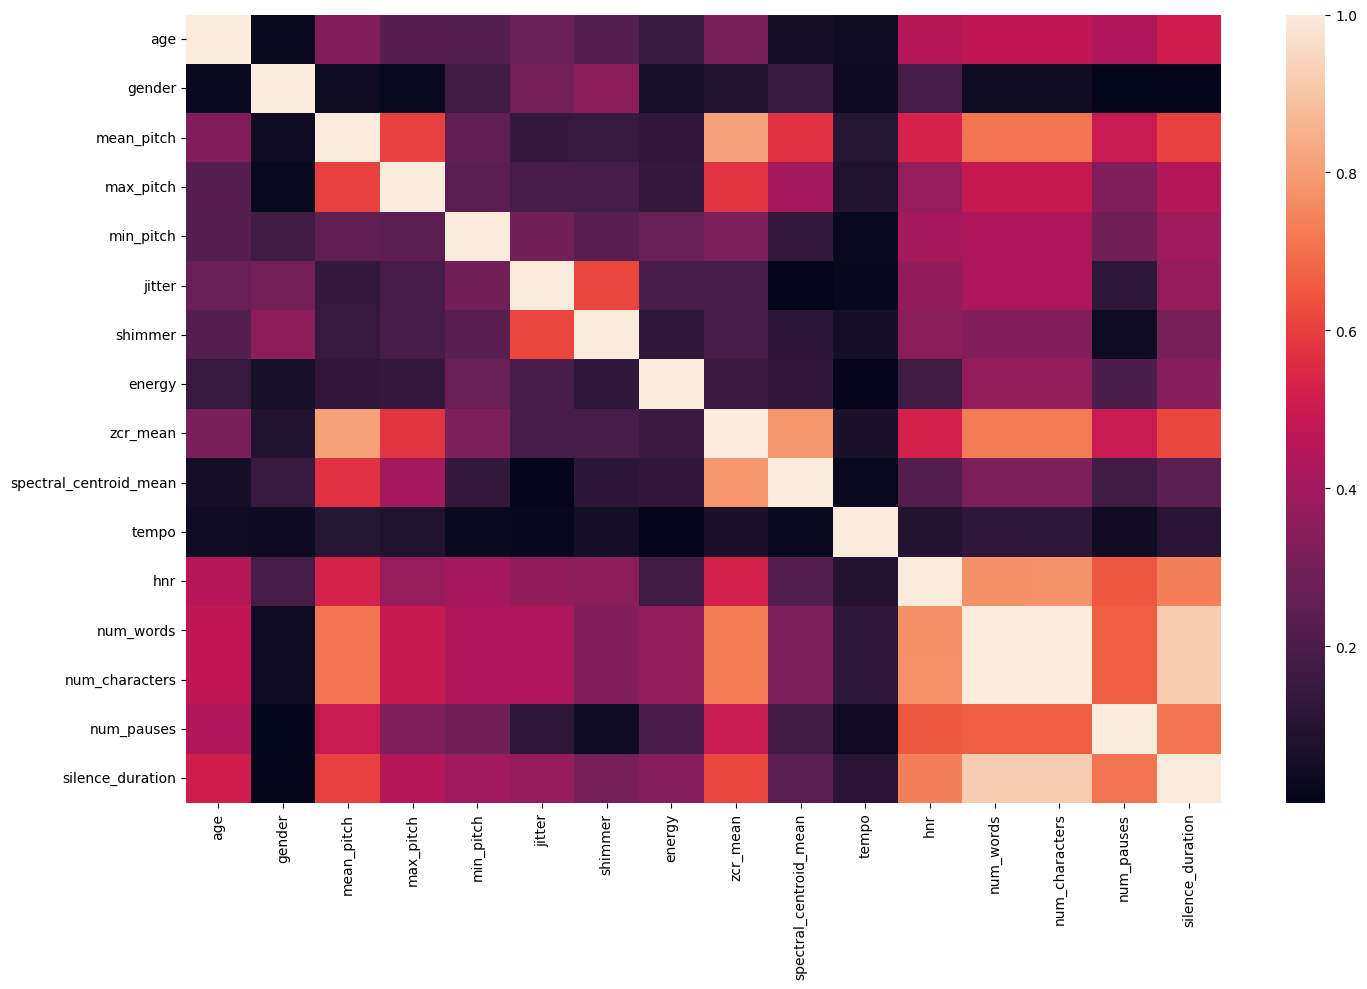

In [94]:
temp:pd.Series = step3_log_dev_df.corr().loc['age', :].sort_values(ascending=False)
display(temp.head(10))
display(temp.tail(10))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
sns.heatmap(np.abs(step3_log_dev_df.corr()), ax=ax)
plt.tight_layout()

### Standardization

In [95]:
no_age_dev_df = step3_log_dev_df.drop(columns=['age'], axis=1)

scaler = StandardScaler().fit(no_age_dev_df)

step3_log_norm_dev_df = pd.DataFrame(scaler.transform(no_age_dev_df), columns=no_age_dev_df.columns)
step3_log_norm_eval_df = pd.DataFrame(scaler.transform(step3_log_eval_df), columns=step3_log_eval_df.columns)

display(step3_log_norm_dev_df.head())
display(step3_log_norm_eval_df.head())

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,-0.998978,1.295444,0.413221,-0.400362,-1.298379,-0.853814,-0.404445,1.534388,1.416622,0.796088,-1.287020,0.844879,0.845057,1.862330,0.954642
1,-0.998978,0.406357,0.411611,-0.415793,0.754143,-0.288687,0.855523,-0.277067,-0.777731,0.121675,-0.322635,0.844879,0.845057,0.601010,0.543263
2,-0.998978,0.476199,0.411505,-0.402148,-0.206386,0.518159,-0.123477,0.258771,0.739585,-0.225751,-0.622378,0.844879,0.845057,-0.800455,0.751095
3,-0.998978,0.661310,0.410845,0.278367,-0.592809,-0.057508,1.920345,1.182793,1.593684,-0.225751,0.469989,0.844879,0.845057,-0.239869,0.566836
4,1.001023,1.096713,0.411146,-0.395821,1.093041,0.682511,0.474725,0.292051,-0.295562,-0.376805,-0.151479,0.844879,0.845057,-0.099722,0.418993


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,1.001023,-0.132027,0.310818,-0.411849,0.288722,1.859285,-0.069907,-1.889152,-1.084587,-1.311455,-1.096143,0.844879,0.845057,-0.730382,2.278922
1,1.001023,0.269560,0.412198,-0.364788,0.913004,0.907538,0.711640,0.558209,0.401067,-1.064363,-0.096969,0.844879,0.845057,1.021450,1.486006
2,1.001023,-0.388885,-0.627155,-0.335666,-0.392564,-0.286866,0.291060,-0.050143,-0.279479,-0.060310,0.075326,-1.077210,-1.090752,-0.730382,-1.035831
3,-0.998978,0.598590,0.411678,-0.405267,1.003108,-0.584964,1.508214,0.106896,-0.484025,-0.060310,-0.702563,0.844879,0.845057,1.301743,0.798232
4,1.001023,1.010125,0.413308,-0.418335,0.217608,-0.004417,-0.909264,0.796607,0.680233,-0.376805,-1.570950,0.844879,0.845057,1.582037,0.823943


## Error plot

In [96]:
def plot_error_distripution(y_pred, y_val, precision):
    errors = pd.DataFrame(np.round(y_pred.flatten() - y_val.values.flatten(), precision), columns=['error'])
    error_counts = errors['error'].value_counts().reset_index()
    error_counts.columns = ['error', 'count']

    plt.figure()
    plt.scatter(error_counts['error'], error_counts['count'])
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Errors')
    plt.show()
    return error_counts

In [19]:
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import cross_val_score

# cross_val_score(make_pipeline(StandardScaler(), RandomForestRegressor()), step3_log_dev_df, ages_df, cv=15, scoring='neq_mean_squared_error').mean().abs()

In [20]:
# let us try several models
models =[
    LinearRegression(),
    RandomForestRegressor(random_state=341967),
    HistGradientBoostingRegressor(random_state=341967),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor(random_state=341967),
    Lasso(random_state=341967),
    Ridge(random_state=341967),
    DecisionTreeRegressor(random_state=341967)
]

names=['Linear reg', 'Random Forest', 'HistGB', 'SVR', 'KNN', 'MLP', 'Lasso', 'Ridge', 'Decision Tree']

In [97]:
t = PrettyTable(['Model', 'RMSE'])
X_train_val_df = step3_log_norm_dev_df.copy()

for model,name in zip(models, names):
    X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    t.add_row([name, root_mean_squared_error(y_val, y_pred)])
print(t)

+---------------+--------------------+
|     Model     |        RMSE        |
+---------------+--------------------+
|   Linear reg  | 11.006757028097923 |
| Random Forest | 10.954255487613231 |
|     HistGB    | 10.858568901060597 |
|      SVR      | 11.394273417450163 |
|      KNN      | 12.315983852796776 |
|      MLP      | 10.736732136495514 |
|     Lasso     | 11.158438602590392 |
|     Ridge     | 11.001198425954156 |
| Decision Tree | 15.783781812780429 |
+---------------+--------------------+


## First regressor

10.954255487613231

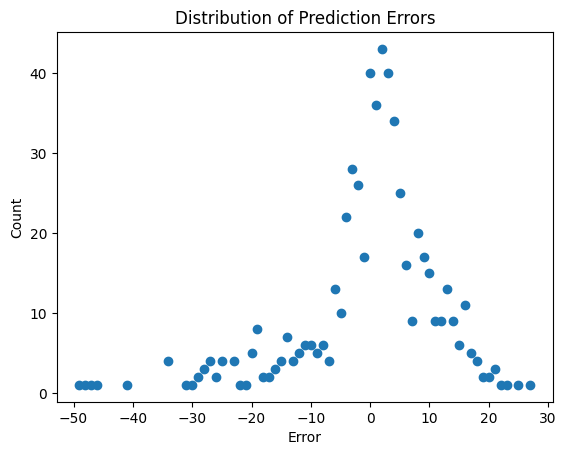

In [98]:
X_train_val_df = step3_log_norm_dev_df.copy()
# X_train_val_df = X_train_val_df.drop(columns=[], axis=1)

forest = RandomForestRegressor(random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.455056281368881

First look to feature importances

In [99]:
imps =sorted(zip(forest.feature_names_in_, forest.feature_importances_), key=lambda x:x[1] , reverse=True)
imps

[('silence_duration', np.float64(0.34097208305010585)),
 ('hnr', np.float64(0.07308107428701854)),
 ('jitter', np.float64(0.06424306744996193)),
 ('spectral_centroid_mean', np.float64(0.06205885974160902)),
 ('shimmer', np.float64(0.06191911252022544)),
 ('mean_pitch', np.float64(0.06190194588900974)),
 ('max_pitch', np.float64(0.05972452857811777)),
 ('min_pitch', np.float64(0.05720407155660831)),
 ('energy', np.float64(0.05694368759294785)),
 ('zcr_mean', np.float64(0.05244572444521123)),
 ('num_pauses', np.float64(0.052264215873769136)),
 ('tempo', np.float64(0.04170968592586419)),
 ('gender', np.float64(0.012203566962229169)),
 ('num_words', np.float64(0.001666078907995454)),
 ('num_characters', np.float64(0.001662297219326421))]

As we can see, only ethnicity "english" seems to give a significant contribution to regressor

In [100]:
y_dev_pred = forest.predict(step3_log_norm_dev_df.values)

display(np.max(y_dev_pred), np.min(y_dev_pred))
display(np.max(ages_df), np.min(ages_df))

np.float64(81.45)

np.float64(13.72)

np.float64(97.0)

np.float64(6.0)

In [25]:
abs(
    cross_val_score(
        RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=341967), 
        X_train_val_df, 
        ages_df, 
        cv=5, 
        scoring='neg_root_mean_squared_error', 
        n_jobs=-1
    ).mean()
)

# abs(
#     croscross_val_score(
#         make_pipeline(StandardScaler(), RandomForestRegressor()), 
#         X_train_val_df, 
#         ages_df, cv=10, 
#         scoring='neg_root_mean_squared_error', 
#         n_jobs=-1
#     ).mean()
# )

np.float64(10.990025811750575)

In [101]:
complete_forest = RandomForestRegressor(n_jobs=5, random_state=341967)
complete_forest.fit(step3_log_norm_dev_df.values, ages_df.values)

y_eval_pred = complete_forest.predict(step3_log_norm_eval_df.values)

with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")

## Fine tuned

In [27]:
# def grid(builder, configs, cv):
#     gs = GridSearchCV(builder(), configs, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)
#     gs.fit(X_train.values, y_train.values.reshape((-1,)))
    
#     return gs

# X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

# best = grid(RandomForestRegressor, {'n_estimators': [300, 500], 'random_state': [341967]}, 5)

# y_pred = best.predict(X_val.values)

# display(root_mean_squared_error(y_val, y_pred))
# _ = plot_error_distripution(y_pred, y_val, 0)

#10.424189101247185

In [298]:
# let us try to split regressor in male/female

def split_gender(X_train_val_df):
    X_train_val_df2 = X_train_val_df.copy()
    
    X_train_male_df = X_train_val_df2[X_train_val_df2['gender'] > 0]
    X_train_female_df = X_train_val_df2[X_train_val_df2['gender'] < 0]

    X_train_male_df.drop(columns=['gender'], axis=1, inplace=True)
    X_train_female_df.drop(columns=['gender'], axis=1, inplace=True)

    display(X_train_male_df)
    display(X_train_female_df)

    return X_train_male_df, X_train_female_df

In [299]:
def split_ages(X_train_val_df, ages_df):
    ages_df2 = ages_df.copy()
    
    ages_male = ages_df2[X_train_val_df['gender'] > 0]
    ages_female = ages_df2[X_train_val_df['gender'] < 0]

    return ages_male, ages_female

In [300]:
def merge_genders(y_male,y_female, index_male, index_female):
    y_male_s = pd.Series(y_male, index=index_male)
    y_female_s = pd.Series(y_female, index=index_female)

    y = pd.concat([y_male_s, y_female_s], axis=0).sort_index()

    return y

In [301]:
def gender_regs(X_train_male_df, X_train_female_df, ages_male, ages_female):
    X_train_male, X_val_male, y_train_male, y_val_male = train_test_split(X_train_male_df, ages_male, test_size=0.2, shuffle=True, random_state=341967)
    X_train_female, X_val_female, y_train_female, y_val_female = train_test_split(X_train_female_df, ages_female, test_size=0.2, shuffle=True, random_state=341967)

    forest_male = RandomForestRegressor(random_state=341967)
    forest_female = RandomForestRegressor(random_state=341967)

    forest_male.fit(X_train_male, y_train_male)
    y_pred_male = forest_male.predict(X_val_male)

    forest_female.fit(X_train_female, y_train_female)
    y_pred_female = forest_female.predict(X_val_female)

    # merge results concatenate y_pred_male e y_pred_female, ordering by index
    # y_pred_male_s = pd.Series(y_pred_male, index=X_val_male.index)
    # y_pred_female_s = pd.Series(y_pred_female, index=X_val_female.index)

    y_val = pd.concat([y_val_male, y_val_female], axis=0).sort_index()
    # y_pred = pd.concat([y_pred_male_s, y_pred_female_s], axis=0).sort_index()
    y_pred = merge_genders(y_pred_male, y_pred_female, X_val_male.index, X_val_female.index)

    # display(y_pred_male_s)
    # display(y_pred_male[:5])
    # display(y_pred)
    # display(y_val)

    # display(root_mean_squared_error(y_val_male, )

    display(root_mean_squared_error(y_val,y_pred))

    return forest_male, forest_female

In [328]:
X_train_male, X_train_female = split_gender(step3_log_norm_dev_df)
ages_male, ages_female = split_ages(step3_log_norm_dev_df, ages_df)

reg_male, reg_female = gender_regs(X_train_male, X_train_female, ages_male, ages_female)

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
4,1.205407,0.411146,-0.395821,1.032230,0.589336,0.026396,0.048513,-0.424086,-0.376805,-0.151479,0.844879,0.845057,-0.099722,0.418993
6,1.447612,0.412951,-0.401807,0.131235,1.054533,-0.626713,1.412521,1.028673,-0.970233,-1.517644,0.844879,0.845057,1.161597,0.770379
9,-1.103980,0.391362,0.271042,-0.521464,0.228935,0.365022,-0.612130,-0.783906,-1.152218,0.714920,-1.107719,-1.090752,-0.800455,-1.113123
10,-0.189020,0.412310,-0.317283,0.060822,-0.193576,0.124059,-0.468991,-0.610619,-0.060310,-0.254363,0.844879,0.845057,0.040424,0.373998
11,0.343070,0.411526,-0.415021,-0.830892,-0.122503,-0.069331,0.702608,0.210056,-0.225751,-0.305166,0.844879,0.845057,0.040424,0.414707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,1.311620,0.413050,-0.364168,-0.202503,0.218898,-0.219148,1.591567,1.132996,1.395567,-0.515314,0.844879,0.845057,0.671084,0.620397
2924,-1.675496,-4.775648,0.493640,4.460926,2.175901,-0.071186,-1.583777,-2.564245,0.322816,1.149475,-1.260266,-1.255184,-0.800455,-1.104716
2926,-1.451203,-0.997936,-0.072457,-0.893085,-1.165323,3.337029,-1.096426,-0.235678,3.248502,0.668177,-1.138228,-1.143071,-0.730382,-0.965125
2928,1.090528,0.412179,-0.410228,0.371027,0.262767,-0.548247,0.136031,0.021567,1.759537,-0.686643,0.844879,0.845057,-0.099722,0.365428


,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,1.526488,0.413221,-0.400362,-1.116336,-0.862609,-0.486481,2.039603,1.616870,0.796088,-1.287020,0.844879,0.845057,1.862330,0.954642
1,0.261473,0.411611,-0.415793,0.627830,-0.396497,0.429809,-0.502063,-0.843696,0.121675,-0.322635,0.844879,0.845057,0.601010,0.543263
2,0.346071,0.411505,-0.402148,-0.320350,0.403982,-0.367850,0.011442,0.691972,-0.225751,-0.622378,0.844879,0.845057,-0.800455,0.751095
3,0.581502,0.410845,0.278367,-0.631887,-0.184536,2.825886,1.334833,1.888962,-0.225751,0.469989,0.844879,0.845057,-0.239869,0.566836
5,0.166581,0.411576,-0.351001,0.672062,-0.474021,1.447764,0.915270,0.301261,-0.060310,-0.492372,0.844879,0.845057,0.601010,0.562547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,0.647983,0.411964,-0.393607,-0.895104,-0.684771,-0.308306,0.593196,-0.295984,-0.970233,-0.887256,0.844879,0.845057,0.390791,0.408280
2927,-0.162739,0.412164,-0.397469,0.884758,0.656932,0.469422,0.138012,-0.544140,-0.642661,0.175654,0.844879,0.845057,-0.800455,1.512491
2929,-0.241320,0.384949,-0.359526,-0.886479,0.655138,-0.801732,-0.663606,0.925998,-1.234405,2.114540,-1.260266,-1.255184,-0.800455,-1.106545
2930,-0.471048,0.393440,0.542899,-1.737977,-0.145028,-0.616548,-0.897263,0.124957,-1.064363,0.536230,-1.229757,-1.187916,-0.800455,-1.094012


11.023203059685493

In [321]:
X_eval_male, X_eval_female = split_gender(step3_log_norm_eval_df)

y_pred_male = reg_male.predict(X_eval_male)
y_pred_female = reg_female.predict(X_eval_female)

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,-0.320241,0.310818,-0.411849,0.134684,2.184013,-0.341252,-1.390696,-1.082816,-1.311455,-1.096143,0.844879,0.845057,-0.730382,2.278922
1,0.102166,0.412198,-0.364788,0.812343,0.856721,0.259332,0.370281,0.291016,-1.064363,-0.096969,0.844879,0.845057,1.021450,1.486006
2,-0.558399,-0.627155,-0.335666,-0.474905,-0.394877,-0.120197,-0.302604,-0.409095,-0.060310,0.075326,-1.077210,-1.090752,-0.730382,-1.035831
4,1.072945,0.413308,-0.418335,0.065148,-0.133977,-0.632135,0.700578,0.618910,-0.376805,-1.570950,0.844879,0.845057,1.582037,0.823943
8,0.665934,0.413123,-0.410169,-0.123561,-0.646200,0.356298,1.035174,0.553997,0.546306,-1.052301,0.844879,0.845057,2.352843,0.961070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,-0.922506,-2.406507,-0.229033,-0.594231,0.428780,-0.750410,-1.065063,-0.138231,-1.064363,-0.197232,-1.260266,-1.255184,-0.800455,-1.018690
686,-1.494505,0.227313,-0.335126,-0.354417,-0.984281,-0.109163,-0.633110,-0.397127,-0.376805,0.822860,-1.077210,-1.143071,-0.800455,-1.073996
687,-0.520128,0.261718,-0.274361,0.479719,0.336241,-0.713017,-0.539820,1.975118,-0.376805,-1.830235,-1.046700,-1.090752,-0.800455,-0.795860
689,1.375527,0.412741,-0.363880,0.743982,-0.045242,-0.247202,0.710718,-0.067122,-0.225751,-0.495225,0.844879,0.845057,-0.169796,0.688960


,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
3,0.499864,0.411678,-0.405267,0.920924,-0.649645,1.594610,-0.149515,-0.594843,-0.060310,-0.702563,0.844879,0.845057,1.301743,0.798232
5,-0.352897,0.365670,1.540887,0.692656,0.036724,-0.696788,-0.944737,-0.752674,0.322816,-0.284318,-1.199247,-1.180442,-0.800455,-1.012982
6,1.196686,0.412974,-0.337753,0.025134,-0.632157,-0.022014,0.890423,0.565992,0.796088,-0.966506,0.844879,0.845057,1.091524,0.549691
7,0.469450,0.364065,0.454869,-0.903139,-1.179053,0.504913,-0.631689,-0.111111,-0.060310,0.739884,-1.077210,-1.143071,-0.730382,-1.063948
11,-1.181101,-2.133234,0.429881,0.386844,-0.332872,-0.687707,-0.716123,0.125839,-0.760251,1.896079,-1.138228,-1.150545,-0.800455,-1.108449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,0.123424,0.401404,0.256755,-0.819483,-1.212825,-0.281507,-0.856150,1.023562,1.077094,1.983812,-1.168738,-1.150545,-0.800455,-1.076653
680,-0.159394,0.412416,-0.334628,0.565119,0.432907,-0.193208,-0.098468,-0.754312,-0.515272,-0.322530,0.844879,0.845057,-0.029649,0.814260
682,-0.083667,0.412597,-0.412905,-0.570448,-0.109651,-0.000043,-0.412748,-0.978844,1.077094,-0.887577,0.844879,0.845057,1.722183,1.509575
683,-0.773398,-1.358641,-0.172122,-0.184494,1.713657,-0.790153,-0.636600,0.406052,-1.311455,0.421948,-1.046700,-1.113174,-0.800455,-0.980077


In [322]:
y_eval_pred = merge_genders(y_pred_male, y_pred_female, X_eval_male.index, X_eval_female.index)

display(y_pred_male)

with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")

array([36.19 , 39.69 , 24.63 , 49.14 , 37.2  , 20.77 , 39.04 , 28.06 ,
       37.26 , 34.18 , 30.545, 34.7  , 24.93 , 23.76 , 28.61 , 22.01 ,
       30.98 , 20.21 , 23.71 , 25.91 , 21.95 , 21.26 , 25.74 , 34.3  ,
       37.96 , 36.61 , 21.54 , 35.21 , 31.68 , 23.71 , 23.72 , 31.135,
       24.95 , 21.77 , 20.23 , 36.21 , 20.03 , 28.17 , 23.15 , 28.35 ,
       23.34 , 29.155, 21.68 , 29.37 , 20.2  , 32.16 , 20.38 , 27.53 ,
       40.53 , 20.72 , 19.47 , 31.83 , 35.4  , 29.2  , 31.94 , 47.53 ,
       20.95 , 27.95 , 21.61 , 21.69 , 26.69 , 18.85 , 23.59 , 23.49 ,
       40.11 , 21.37 , 22.94 , 21.32 , 33.84 , 37.5  , 34.36 , 27.12 ,
       25.05 , 20.34 , 39.94 , 20.46 , 35.42 , 20.93 , 21.04 , 33.15 ,
       39.11 , 28.84 , 33.49 , 37.19 , 21.91 , 19.71 , 32.35 , 39.35 ,
       32.48 , 31.1  , 43.61 , 19.68 , 28.55 , 21.77 , 31.52 , 34.04 ,
       34.94 , 37.41 , 22.705, 22.97 , 23.799, 20.52 , 34.62 , 39.56 ,
       35.07 , 21.83 , 20.42 , 20.81 , 19.59 , 21.64 , 24.61 , 36.07 ,
      

## Preprocess audio

In [35]:
# # try cleaning the audios
# for i in range(len(audio_dev)):
#     y, sr = librosa.load(AUDIOS_DEVELOPMENT + audio_dev[i], sr=sampling_rate)

#     reduced = nr.reduce_noise(y=y, sr=sr)

#     wavfile.write(AUDIOS_DEVELOPMENT_CLEANED + audio_dev[i], sr, y)

In [36]:
# # try cleaning the audios
# for i in range(len(audio_eval)):
#     y, sr = librosa.load(AUDIOS_EVALUATION + audio_eval[i], sr=sampling_rate)

#     reduced = nr.reduce_noise(y=y, sr=sr)

#     wavfile.write(AUDIOS_EVALUATION_CLEANED + audio_eval[i], sr, y)

### Data exploration

In [131]:
def plot_audio(y:np.ndarray, sr:float, time=False, freq=False, spectrogram=False, mel=False, mfcc=False, hp=False, poly=False,plot=True):
    """
        Returns the thing plotted\n
        If freq = True, returns the frequencies used too\n
        If hp=True, returns Harmonic and Percussion\n
        If all False, returns y
    """
    n_fft = (FREQ_BIN - 1) * 2

    if time:
        if plot:
            plt.figure(figsize=(12, 3))
            plt.title(f"Audio {i} as waveform")
            librosa.display.waveshow(y, sr=sr)

        return y
    if freq:
        y_freq = np.abs(scipy.fft.fft(y))
        f = np.linspace(0, sr, len(y_freq))
        
        if plot:
            plt.figure(figsize=(12, 3))
            plt.title(f"Spectrum of audio {i}")
            plt.semilogx(f[: len(f) // 2], y_freq[: len(f) // 2])
            plt.xlabel("Frequency (Hz)")

        return y_freq, f
    if spectrogram:    
        y_stft = np.abs(librosa.stft(y, n_fft=n_fft))
        y_stft_db = librosa.amplitude_to_db(y_stft, ref=np.max)
        
        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"Spectrogram of audio {i}")
            librosa.display.specshow(y_stft_db, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.1f dB")

        return y_stft, y_stft_db
    if mel:
        y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=FREQ_BIN)
        y_mel_db = librosa.power_to_db(y_mel, ref=np.max)

        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"Mel-spectrogram of audio {i}")
            librosa.display.specshow(y_mel_db, sr=sr, x_axis="time", y_axis="mel")
            plt.colorbar(format="%.2f dB")
        
        return y_mel, y_mel_db
    if mfcc:
        y_mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        # y_mfccs = y.to_mfcc(number_of_coefficients=N_MFCC-1).to_array()
        
        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"MFCC of audio {i}")
            librosa.display.specshow(y_mfccs, sr=sr, x_axis="time")
            plt.colorbar()

        return y_mfccs
    if hp:
        y_stft = librosa.stft(y, n_fft=n_fft)
        H, P = librosa.decompose.hpss(y_stft)
        Hmag = np.abs(H)
        Pmag = np.abs(P)

        if plot:
            Hdb = librosa.amplitude_to_db(Hmag, ref=np.max)
            Pdb = librosa.amplitude_to_db(Pmag, ref=np.max)
            
            plt.figure(figsize=(12, 4))
            plt.title(f"Harmonic source of audio {i}")
            librosa.display.specshow(Hdb, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.2f dB")

            plt.figure(figsize=(12, 4))
            plt.title(f"Percussive source of audio {i}")
            librosa.display.specshow(Pdb, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.2f dB")

        return librosa.istft(H), Hmag, librosa.istft(P), Pmag
    if poly:
        y_poly = librosa.feature.poly_features(y=y, sr=sr)

        if plot:
            plt.figure(figsize=(12, 8))
            plt.title(f"Polynomial feature of audio {i}")
            plt.plot(y_poly[0], label="Coeffs order 0")
            plt.plot(y_poly[1], label="Coeffs order 1")
            plt.legend()

        return y_poly
    plt.show()

    return y

#### Time domain

In [146]:
def time_domain(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    res = pd.DataFrame(
        0.0, 
        index=[audio_id], 
        columns=[
            'audio_length', 'mean_absolute_slope'
        ]
    )

    sr = sampling_rate
    pitch = parselmouth.Sound(dir+audio).to_pitch()

    y = pitch.selected_array
    y = y[~(y['frequency'] == 0)]

    median_pitch = np.nanmedian(y['frequency'])
    median_pitch_i = np.argmin(abs(y['frequency'] - median_pitch))

    median_pitch_strength = y['strength'][median_pitch_i]

    pitch_iqr = scipy.stats.iqr(y['frequency'])

    mean_absolute_slope = pitch.get_mean_absolute_slope()
    voiced_frames = pitch.count_voiced_frames()
    number_of_frames = pitch.get_number_of_frames()

    min_pitch = np.min(y['frequency'])
    max_pitch = np.max(y['frequency'])
    # print(pitch.info())

    # display(mean_absolute_slope, voiced_frames, number_of_frames)
    # print(features.all_temporal_features(y.values[0], sampling_rate))

    series = features.all_temporal_features(librosa.load(dir+audio, sr = sr)[0], fs=sr, nperseg=256)
    series.index = [audio_id]

    res.loc[audio_id, 'audio_length'] = pitch.duration
    res.loc[audio_id, 'mean_absolute_slope'] = mean_absolute_slope
    # res.loc[audio_id, 'median_pitch_pm'] = median_pitch
    # res.loc[audio_id, 'median_pitch_strength'] = median_pitch_strength
    # res.loc[audio_id, 'pitch_iqr'] = pitch_iqr
    # res.loc[audio_id, 'min_pitch_pm'] = min_pitch
    # res.loc[audio_id, 'max_pitch_pm'] = max_pitch
    res.loc[audio_id, 'voiced_frames'] = voiced_frames
    res.loc[audio_id, 'number_of_frames'] = number_of_frames

    if plot:
        plot_audio(y, sr, time=True, plot=plot)

        print(f"Audio: {audio_id}")
        print(f"Length: {pitch.duration}")
    return res

time_domain(AUDIOS_DEVELOPMENT, audio_dev[0])

,audio_length,mean_absolute_slope
0,35.120522,301.742399


In [39]:
sound = parselmouth.Sound(AUDIOS_DEVELOPMENT+audio_dev[0])
pitch = call(sound, "To Pitch", 0.0, 100, 9000)
pulse = call([sound, pitch], "To PointProcess (cc)")

voice_report = call([sound, pitch, pulse], "Voice report", 0.0, 0.0, 75, 600, 1.3, 1.6, 0.03, 0.45).split(chr(10))

display(voice_report)

['   From 0 to 0 seconds (duration: 35.120522 seconds)',
 'Pitch:',
 '   Median pitch: 233.118 Hz',
 '   Mean pitch: 965.110 Hz',
 '   Standard deviation: 2330.481 Hz',
 '   Minimum pitch: 103.973 Hz',
 '   Maximum pitch: 9013.357 Hz',
 'Pulses:',
 '   Number of pulses: 14613',
 '   Number of periods: 3596',
 '   Mean period: 4.294335E-3 seconds',
 '   Standard deviation of period: 0.963306E-3 seconds',
 'Voicing:',
 '   Fraction of locally unvoiced frames: 53.387%   (2498 / 4679)',
 '   Number of voice breaks: 73',
 '   Degree of voice breaks: 43.205%   (15.173706 seconds / 35.120522 seconds)',
 'Jitter:',
 '   Jitter (local): 1.344%',
 '   Jitter (local, absolute): 57.704E-6 seconds',
 '   Jitter (rap): 0.503%',
 '   Jitter (ppq5): 0.564%',
 '   Jitter (ddp): 1.508%',
 'Shimmer:',
 '   Shimmer (local): 8.074%',
 '   Shimmer (local, dB): 0.830 dB',
 '   Shimmer (apq3): 2.941%',
 '   Shimmer (apq5): 4.352%',
 '   Shimmer (apq11): 7.916%',
 '   Shimmer (dda): 8.824%',
 'Harmonicity of t

#### Frequency domain

In [87]:
def freq_domain(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1
    res = pd.DataFrame(0, index=[audio_id], columns=['dominant_frequency', 'highest_freq_in_spectrum', 'lowest_freq_in_spectrum', 'spectrum_wide'], dtype=float)

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    y_freq, f = plot_audio(y, sr, freq=True, plot=plot)

    y_mag = np.abs(y_freq)
    dominant_frequency = f[np.argmax(y_mag)]

    threshold = np.max(y_mag) * 0.1
    significant_freqs = f[y_mag > threshold]

    if len(significant_freqs) > 0:
        lowest_freq_in_spectrum, highest_freq_in_spectrum = significant_freqs[0], significant_freqs[-1]
    else:
        lowest_freq_in_spectrum, highest_freq_in_spectrum = 0, 0

    spectrum_wide = highest_freq_in_spectrum - lowest_freq_in_spectrum
    res.loc[audio_id, 'dominant_frequency'] = dominant_frequency
    res.loc[audio_id, 'lowest_freq_in_spectrum'] = lowest_freq_in_spectrum
    res.loc[audio_id, 'highest_freq_in_spectrum'] = highest_freq_in_spectrum
    res.loc[audio_id, 'spectrum_wide'] = spectrum_wide

    if plot:
        print(f"Audio: {audio}")
        print(f"Dominant frequency: {dominant_frequency}")

        print(f"Lowest important freq:{lowest_freq_in_spectrum}")
        print(f"Highest important freq:{highest_freq_in_spectrum}")
        print(f"Length of spectrum: {highest_freq_in_spectrum - lowest_freq_in_spectrum}\n")

    return res

#### Spectrogram

In [108]:
def spectrogram(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    spect_frequency_mean_cols = [f"spect_frequency_mean_{t}" for t in range(FREQ_BIN)]
    spect_frequency_var_cols  = [f"spect_frequency_var_{t}" for t in range(FREQ_BIN)]

    res = pd.DataFrame(0, index=[audio_id], columns=['spect_overall_mean', 'spect_overall_var'] + spect_frequency_mean_cols + spect_frequency_var_cols, dtype=float)

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    S, Sdb= plot_audio(y, sr, spectrogram=True, plot=plot)

    # spect_temporal_mean = S.mean(axis=0)
    # spect_temporal_variance = S.var(axis=0)
    # spect_temporal_skewness = skew(S, axis=0)
    # spect_temporal_kurtosis = kurtosis(S, axis=0)

    spect_frequency_mean = S.mean(axis=1)
    spect_frequency_variance = S.var(axis=1)
    spect_frequency_skewness = skew(S, axis=1)
    spect_frequency_kurtosis = kurtosis(S, axis=1)

    spect_overall_mean = S.mean()
    spect_overall_var = S.var()

    frequencies = librosa.fft_frequencies(sr=sr)  # sr is the sample rate of the audio

    # Find the indices corresponding to 250 Hz and 650 Hz
    low_idx = np.argmax(frequencies >= 250)
    high_idx = np.argmax(frequencies >= 650)
    energy = np.sum(np.abs(S)[low_idx:high_idx, :]**2)

    res.loc[audio_id, 'spect_overall_mean'] = spect_overall_mean
    res.loc[audio_id, 'spect_overall_var'] = spect_overall_var

    res.loc[audio_id, spect_frequency_mean_cols] = spect_frequency_mean
    res.loc[audio_id, spect_frequency_var_cols] = spect_frequency_variance

    res.loc[audio_id, 'spectralEnergy250-650'] = energy
    
    if plot:
        print(f"Audio: {audio}")
        # print(f"Temporal mean:\n{spect_temporal_mean}")
        # print(f"Temporal variance:\n{spect_temporal_variance}")
        # print(f"Temporal skewness:\n{spect_temporal_skewness}")
        # print(f"Temporal kurtosis:\n{spect_temporal_kurtosis}")
        
        print(f"Overall mean:\n{S.mean()}")
        print(f"Overall variance:\n{S.var()}")
        
        print(f"Frequency mean:\n{spect_frequency_mean}")
        print(f"Frequency variance:\n{spect_frequency_variance}")
        print(f"Frequency skewness:\n{spect_frequency_skewness}")
        print(f"Frequency kurtosis:\n{spect_frequency_kurtosis}")

        # display(spect_temporal_mean.shape)    

    return res

#### Mel-spectrogram

In [89]:
def mel_spectrogram(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    mel_frequency_mean_cols = [f"mel_frequency_mean_{t}" for t in range(FREQ_BIN)]
    mel_frequency_var_cols  = [f"mel_frequency_var_{t}" for t in range(FREQ_BIN)]

    res = pd.DataFrame(0, index=[audio_id], columns=['mel_overall_mean', 'mel_overall_var']+mel_frequency_mean_cols+mel_frequency_var_cols, dtype=float)
    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    S, S_db = plot_audio(y, sr, mel=True, plot=plot)

    # mel_temporal_mean =     S.mean(axis=0)
    # mel_temporal_variance = S.var(axis=0)
    # mel_temporal_skewness = skew(S, axis=0)
    # mel_temporal_kurtosis = kurtosis(S, axis=0)

    mel_frequency_mean =     S.mean(axis=1)
    mel_frequency_variance = S.var(axis=1)
    mel_frequency_skewness = skew(S, axis=1)
    mel_frequency_kurtosis = kurtosis(S, axis=1)

    overall_mean = S.mean()
    overall_var = S.var()

    res.loc[audio_id, 'mel_overall_mean'] = overall_mean
    res.loc[audio_id, 'mel_overall_var'] = overall_var

    res.loc[audio_id, mel_frequency_mean_cols] = mel_frequency_mean
    res.loc[audio_id, mel_frequency_var_cols] = mel_frequency_variance

    if plot:
        print(f"Audio: {audio}")
        
        print(f"Overall mean:\n{overall_mean}")
        print(f"Overall variance:\n{overall_var}")
        
        print(f"Frequency mean:    \n{mel_frequency_mean}")
        print(f"Frequency variance:\n{mel_frequency_variance}")
        print(f"Frequency skewness:\n{mel_frequency_skewness}")
        print(f"Frequency kurtosis:\n{mel_frequency_kurtosis}")
        display('')

    return res

#### Mel-frequency cepstral coefficients (MFCC)

In [90]:
def mfcc(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    mfcc_frequency_mean_cols = [f"mfcc_frequency_mean_{t}" for t in range(N_MFCC)]
    mfcc_frequency_var_cols  = [f"mfcc_frequency_var_{t}"  for t in range(N_MFCC)]   

    audio_id = int(audio.split('.')[0])-1
    res = pd.DataFrame(0, index=[audio_id], columns=mfcc_frequency_mean_cols, dtype=float)

    sr = sampling_rate
    
    y, sr = librosa.load(dir+audio, sr=sr)

    S = plot_audio(y, sr, mfcc=True, plot=plot)

    # mfcc_temporal_mean     = S.mean(axis=0)
    # mfcc_temporal_variance = S.var(axis=0)
    # mfcc_temporal_skewness = skew(S, axis=0)
    # mfcc_temporal_kurtosis = kurtosis(S, axis=0)

    mfcc_frequency_mean = S.mean(axis=1)
    mfcc_frequency_variance = S.var(axis=1)
    mfcc_frequency_skewness = skew(S, axis=1)
    mfcc_frequency_kurtosis = kurtosis(S, axis=1)

    # print(temporal_mean

    serie = pd.Series(mfcc_frequency_mean, index=mfcc_frequency_mean_cols)
    
    res.loc[audio_id, mfcc_frequency_mean_cols] = serie
    # res.loc[audio_id, mfcc_frequency_var_cols] = mfcc_frequency_variance
    
    if plot:
        print(f"Audio: {audio}")
        
        print(f"Frequency mean:    \n{mfcc_frequency_mean}")
        print(f"Frequency variance:\n{mfcc_frequency_variance}")
        print(f"Frequency skewness:\n{mfcc_frequency_skewness}")
        print(f"Frequency kurtosis:\n{mfcc_frequency_kurtosis}")
    return res
mfcc(AUDIOS_DEVELOPMENT, audio_dev[5])

,mfcc_frequency_mean_0,mfcc_frequency_mean_1,mfcc_frequency_mean_2,mfcc_frequency_mean_3,mfcc_frequency_mean_4,mfcc_frequency_mean_5,mfcc_frequency_mean_6,mfcc_frequency_mean_7,mfcc_frequency_mean_8,mfcc_frequency_mean_9,...,mfcc_frequency_mean_25,mfcc_frequency_mean_26,mfcc_frequency_mean_27,mfcc_frequency_mean_28,mfcc_frequency_mean_29,mfcc_frequency_mean_30,mfcc_frequency_mean_31,mfcc_frequency_mean_32,mfcc_frequency_mean_33,mfcc_frequency_mean_34
5,-269.15094,99.87159,12.352244,14.156068,-3.168328,-9.993343,-16.430872,1.099884,-11.660812,-8.169755,...,-1.484924,-6.773746,-1.099496,-1.134278,-0.832042,-3.760564,-0.211587,-1.913401,1.860242,-1.327836


#### Harmonic-percussive source separation

In [91]:
def hpss(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    harmonic_frequency_mean_cols = [f"harmonic_frequency_mean_{t}" for t in range(FREQ_BIN)]
    harmonic_frequency_var_cols = [f"harmonic_frequency_var_{t}" for t in range(FREQ_BIN)]

    percussion_frequency_mean_cols = [f"percussion_frequency_mean_{t}" for t in range(FREQ_BIN)]
    percussion_frequency_var_cols = [f"percussion_frequency_var_{t}" for t in range(FREQ_BIN)]

    res = pd.DataFrame(
        0, 
        index=[audio_id], 
        columns=
            ['harmonic_overall_mean', 'harmonic_overall_var', 'percussion_overall_mean', 'percussion_overall_var']+
            harmonic_frequency_mean_cols+
            harmonic_frequency_var_cols+
            percussion_frequency_mean_cols+
            percussion_frequency_var_cols,
        dtype=float
    )

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    h, Hmag, p, Pmag = plot_audio(y, sr, hp=True, plot=plot)
    
    harmonic_frequency_mean     = Hmag.mean(axis=1)
    harmonic_frequency_variance = Hmag.var(axis=1)

    percussion_frequency_mean =     Pmag.mean(axis=1)
    percussion_frequency_variance = Pmag.var(axis=1)

    harmonic_overall_mean = Hmag.mean()
    harmonic_overall_var = Hmag.var()

    percussion_overall_mean = Pmag.mean()
    percussion_overall_var = Pmag.var()

    res.loc[audio_id, 'harmonic_overall_mean'] = harmonic_overall_mean
    res.loc[audio_id, 'harmonic_overall_var'] = harmonic_overall_var        
    res.loc[audio_id, 'percussion_overall_mean'] = percussion_overall_mean
    res.loc[audio_id, 'percussion_overall_var'] = percussion_overall_var

    res.loc[audio_id, harmonic_frequency_mean_cols] = harmonic_frequency_mean
    res.loc[audio_id, harmonic_frequency_var_cols] = harmonic_frequency_variance
    res.loc[audio_id, percussion_frequency_mean_cols] = percussion_frequency_mean
    res.loc[audio_id, percussion_frequency_var_cols] = percussion_frequency_variance

    if plot:
        print(f"Overall mean for harmonic source:\n{harmonic_overall_mean}")
        print(f"Overall variance for harmonic source:\n{harmonic_overall_var}")
        print(f"Overall mean for percussion source:\n{percussion_overall_mean}")
        print(f"Overall variance for percussion source:\n{percussion_overall_var}")

        display("")
        
        plot_audio(h, sr, mfcc=True, plot=plot)
        plot_audio(p, sr, mfcc=True, plot=plot)

    return res

#### Zero-crossing rate

In [92]:
def zcr(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    res = pd.DataFrame(0, index=[audio_id], columns=['zcr'], dtype=float)
    
    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    zero_astfly = librosa.zero_crossings(y, pad=False).sum()
    zcr_ = float(zero_astfly/(y.shape[0]/sr))

    res.loc[audio_id, 'zcr'] = zcr_

    if plot:
        display(zcr_)

    return res


#### Polyfeatures

In [93]:
def poly(dir, audio, plot=False):
    audio_id = int(audio.split('.')[0])-1

    res = pd.DataFrame(0, index=[audio_id], columns=['mean_coeffs', 'std_coeffs'], dtype=float)
    
    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    y_poly = plot_audio(y, sr, poly=True, plot=plot)

    res.loc[audio_id, 'mean_coeffs'] = y_poly[1].mean()
    res.loc[audio_id, 'std_coeffs'] = y_poly[1].std()

    return res

#### Fundamental Frequency

In [47]:
def fund_freq_fast(dir, file):
    res = pd.DataFrame(0,index=[file], columns=['f0', 'std_f0'], dtype=float)
    # Load the audio file
    audio = pm.Sound(dir+file)

    # Extract pitch (fundamental frequency)
    pitch = audio.to_pitch()

    # Get time and f0 values
    times = pitch.xs()  # Time stamps
    f0_values = pitch.selected_array['frequency']  # Frequency values in Hz

    # Replace unvoiced frames (f0 = 0) with NaN for better handling
    f0_values[f0_values == 0] = float("nan")

    f0_values = f0_values[~np.isnan(f0_values)]
    print(np.median(f0_values))
    print(np.std(f0_values))

    res.loc[file, 'f0'] = np.median(f0_values)
    res.loc[file, 'std_f0'] = np.std(f0_values)

    return res
      

fund_freq_fast(AUDIOS_DEVELOPMENT, audio_dev[0])
print('Gender: ', dev_df.iloc[0]['gender'])
print('Age: ', ages_df.iloc[0])

227.17385236291207
54.9008965097821
Gender:  female
Age:  age    24.0
Name: 0, dtype: float64


In [48]:
def fundamental_freq(dir, audio, plot=False):
    res = pd.DataFrame(0, index=[audio], columns=['f0'], dtype=float)

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    fmin = librosa.note_to_hz('C2')
    fmax = librosa.note_to_hz('C7')

    f0, voiced_flag, voiced_probs = librosa.pyin(y,fmin=fmin, fmax=fmax,n_thresholds=10 ,sr=sr)

    f0 = f0[voiced_flag]
    # print(f0.mean())

    A = librosa.lpc(y=y, order=2+sr//1000)
    rts = np.roots(A)
    reals = np.imag(rts) >=0

    if np.sum(reals) >=2:
        rts = rts[reals]
        angz = np.arctan2(np.imag(rts), np.real(rts))
        frqs = angz * sr / (2 * np.pi)
        frqs.sort()

        f1 = frqs[0]
        f2 = frqs[1]
    else:
        f1 = 0
        f2 = 0

    res.loc[audio, 'f0'] = f0.mean()
    res.loc[audio, 'f1'] = f1
    res.loc[audio, 'f2'] = f2

    return res

# for i in range(len(first_five)):
#     fundamental_freq(AUDIOS_DEVELOPMENT, first_five[i], plot=False)
#     print(f'Audio {i}')
#     print('Gender: ', dev_df.iloc[i]['gender'])
#     print('Age: ', ages_df.iloc[i])

In [94]:
def measureFormants(dir, audio, f0min=75,f0max=600):
    audio_id = int(audio.split('.')[0])-1
    
    res = pd.DataFrame(
        0.0, 
        index=[audio_id], 
        columns=[
            'f0_mean', 'f1_mean', 'f2_mean', 'f3_mean', 'f4_mean', 
            'f1_median', 'f2_median', 'f3_median', 'f4_median', 
            'f0_var', 'f1_var', 'f2_var', 'f3_var', 'f4_var'
        ]
    )
    sound = parselmouth.Sound(dir+audio) # read the sound
    pitch = call(sound, "To Pitch (cc)", 0, f0min, 15, 'no', 0.03, 0.45, 0.01, 0.35, 0.14, f0max)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    
    formants = call(sound, "To Formant (burg)", 0.0025, 5, 5000, 0.025, 50)
    numPoints = call(pointProcess, "Get number of points")

    f0_mean = call(pitch, "Get mean", 0, 0, "Hertz") # get mean pitch
    f0_var = call(pitch, "Get standard deviation", 0 ,0, "Hertz")**2 # get standard deviation

    f1_list = []
    f2_list = []
    f3_list = []
    f4_list = []
    
    # Measure formants only at glottal pulses
    for point in range(0, numPoints):
        point += 1
        t = call(pointProcess, "Get time from index", point)
        f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f4 = call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
    
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    f2_list = [f2 for f2 in f2_list if str(f2) != 'nan']
    f3_list = [f3 for f3 in f3_list if str(f3) != 'nan']
    f4_list = [f4 for f4 in f4_list if str(f4) != 'nan']
    
    # calculate mean formants across pulses
    f1_mean = statistics.mean(f1_list)
    f2_mean = statistics.mean(f2_list)
    f3_mean = statistics.mean(f3_list)
    f4_mean = statistics.mean(f4_list)
    
    # calculate median formants across pulses, this is what is used in all subsequent calcualtions
    # you can use mean if you want, just edit the code in the boxes below to replace median with mean
    f1_median = statistics.median(f1_list)
    f2_median = statistics.median(f2_list)
    f3_median = statistics.median(f3_list)
    f4_median = statistics.median(f4_list)

    f1_var = statistics.variance(f1_list)
    f2_var = statistics.variance(f2_list)
    f3_var = statistics.variance(f3_list)
    f4_var = statistics.variance(f4_list)
    
    res.loc[audio_id, 'f0_mean'] = f0_mean
    res.loc[audio_id, 'f1_mean'] = f1_mean
    res.loc[audio_id, 'f2_mean'] = f2_mean
    res.loc[audio_id, 'f3_mean'] = f3_mean
    res.loc[audio_id, 'f4_mean'] = f4_mean
    res.loc[audio_id, 'f1_median'] = f1_median
    res.loc[audio_id, 'f2_median'] = f2_median
    res.loc[audio_id, 'f3_median'] = f3_median
    res.loc[audio_id, 'f4_median'] = f4_median
    res.loc[audio_id, 'f0_var'] = f0_var
    res.loc[audio_id, 'f1_var'] = f1_var
    res.loc[audio_id, 'f2_var'] = f2_var
    res.loc[audio_id, 'f3_var'] = f3_var
    res.loc[audio_id, 'f4_var'] = f4_var

    return res

measureFormants(AUDIOS_DEVELOPMENT, audio_dev[0])

,f0_mean,f1_mean,f2_mean,f3_mean,f4_mean,f1_median,f2_median,f3_median,f4_median,f0_var,f1_var,f2_var,f3_var,f4_var
0,230.672182,562.805261,1618.299004,2643.320944,3510.873206,543.461542,1595.061548,2697.209913,3445.396022,2813.567191,34429.560045,219530.519863,151540.763589,208844.962303


In [50]:
def computeTemporalMedia(dir, audio):
    audio_id = int(audio.split('.')[0])-1
    
    res = pd.DataFrame(0.0, index=[audio_id], columns=['temporalMedian'])

    s, sr = librosa.load(dir+audio, sr=sampling_rate)

    med = features.temporal_median(s)

    res.loc[audio_id, 'temporalMedian'] = med

    return res
computeTemporalMedia(AUDIOS_DEVELOPMENT, audio_dev[0])

,temporalMedian
0,0.046026


In [95]:
def computeEntropy(dir, audio):
    audio_id = int(audio.split('.')[0])-1
    
    res = pd.DataFrame(0.0, index=[audio_id], columns=['temporal_entropy','frequence_entropy', 'mean_spectral_entropy'])

    s, sr = librosa.load(dir+audio, sr=sampling_rate)
    Ht = maad.features.temporal_entropy(s)

    Sxx_power,tn,fn,_ = maad.sound.spectrogram(s, sr)   
    Hf, Ht_per_bin = maad.features.frequency_entropy(Sxx_power)
    EAS, ECU, ECV, EPS, EPS_KURT, EPS_SKEW = maad.features.spectral_entropy(Sxx_power, fn, flim=(2000,10000)) 
    print(Hf)

    res.loc[audio_id, 'temporal_entropy'] = Ht
    res.loc[audio_id, 'frequence_entropy'] = Hf
    res.loc[audio_id, 'mean_spectral_entropy'] = EAS

    return res
computeEntropy(AUDIOS_DEVELOPMENT, audio_dev[0])

0.7184801697663455


,temporal_entropy,frequence_entropy,mean_spectral_entropy
0,0.809055,0.71848,0.141662


In [52]:
# all_features = Parallel(n_jobs=9)(
#     delayed(computeEntropy)(AUDIOS_EVALUATION, file) for file in tqdm(audio_eval)
# )

# tot = pd.concat(all_features)
# tot.index.name = 'audio_id'

# tot.isna().sum()

# tot.fillna(tot['temporal_entropy'].mode()[0], inplace=True)
# tot.isna().sum()

# tot.to_csv("Features/eval/entropy.csv")
# display(tot)

#### TODO

In [53]:
#### Spectral energy
def spectral_energy(dir, audio, plot=False):
    S = librosa.stft(audio)
    freqs = librosa.fft_frequencies(sr=22050)
    return pd.Series([np.sum(np.abs(S[(freqs >= 250) & (freqs <= 650)])**2), np.sum(np.abs(S[(freqs >= 1000) & (freqs <= 8000)])**2)],
                        index=['spectralEnergy250-650', 'spectralEnergy1000-8000'])
#### Maad
def computeMaadStats(audio):
    Sxx_power, tn, fn, _ = sound.spectrogram(audio, 22050)      
    return pd.Series([features.number_of_peaks(Sxx_power, fn=fn, nperseg=256), 
                      features.bioacoustics_index(Sxx_power, fn=fn, flim=(100, 3000)),
                      features.acoustic_diversity_index(Sxx_power, fn=fn, fmin=80, fmax=3000),
                      features.acoustic_eveness_index(Sxx_power, fn=fn, fmin=80, fmax=3000),
                    # features.roughness(Sxx_power)
                      ],
                    index=['nPeaks', 'bioIndex', 'acousticDiversity', 'acousticEvenness'])
#### Parselmouth
def computeF0(audio):
    sound = parselmouth.Sound(audio)
    pitch = sound.to_pitch()
    info = str(pitch.info()).split('\n')
    return pd.Series([pitch.count_voiced_frames(), pitch.get_mean_absolute_slope(), pitch.xmax-pitch.xmin, 
                      pitch.n_frames, *[float(info[15+i].split('=')[2].lstrip().split(' =')[0].split()[0]) for i in range(0, 5)],
                      *[float(info[21+i].split('=')[2].lstrip().split(' =')[0].split()[0]) for i in range(0, 3)]],
                     index=['nVoicedFrames', 'meanAbsoluteSlope', 'duration', 'nFrames', 
                            'q10', 'q16', 'q50', 'q84', 'q90', '84-median', 'median-16', '90-10']
                     )
from scipy.fftpack import hilbert


def computeMath(audio):
    return pd.Series([skew(audio), 
                    kurtosis(audio), 
                    np.mean(np.abs(hilbert(audio))),
                    np.mean(np.abs(np.fft.fft(audio)))
                    ],
                    index=['skew', 'kurtosis', 'hilbertMean', 'fftMean'], dtype=float)
def computSNR(audio):
    return pd.Series([sound.temporal_snr(audio)[-1]],
                        index=['temporalSNR'])
def computeAllFeatures(audio):
    return pd.Series(features.all_temporal_features(audio, fs=22050, nperseg=256).iloc[0],
                     index=['sm', 'sv', 'ss', 'sk', 'Time 5%', "Time 25%", "Time 50%", "Time 75%", "Time 95%", 
                            "zcr", "duration_50", "duration_90"])
def computePeakFrequency(audio):
    return pd.Series(features.peak_frequency(audio, fs=22050, nperseg=256, amp=True),
                     index=['peakFrequency', 'peakFrequencyAmp'])

#### Tested audios

In [54]:
test_audios = np.random.choice(audio_dev, 3)
first_five = audio_dev[:5]

In [55]:
all_features = pd.DataFrame()

for audio in tqdm(test_audios):
    # time = time_domain(AUDIOS_DEVELOPMENT, audio, plot=False)
    # freq = freq_domain(AUDIOS_DEVELOPMENT, audio, plot=False)
    # spec = spectrogram(AUDIOS_DEVELOPMENT, audio, plot=False)
    # mel = mel_spectrogram(AUDIOS_DEVELOPMENT, audio, plot=False)
    # mfccs = mfcc(AUDIOS_DEVELOPMENT, audio, plot=False)
    # hp = hpss(AUDIOS_DEVELOPMENT, audio, plot=False)
    # zcrs = zcr(AUDIOS_DEVELOPMENT, audio, plot=False)
    # poly_feats = poly(AUDIOS_DEVELOPMENT, audio, plot=False)
    fund_freq = fundamental_freq(AUDIOS_DEVELOPMENT, audio, plot=False)  
    
    features = pd.concat([fund_freq], axis=1)

    features.index.name = 'audio_name'

    all_features = pd.concat([all_features, features])

display(all_features)

100%|██████████| 3/3 [00:58<00:00, 19.49s/it]


,f0,f1,f2
audio_name,,,
2886.wav,128.477390,36.635222,608.076777
1154.wav,192.936497,331.495058,528.935641
1013.wav,245.374846,356.561515,606.411696


In [56]:
def extract_all_features_old(audios, plot=False):
    # extract features

    time = time_domain(audios, plot)
    freq = freq_domain(audios, plot)
    spec = spectrogram(audios, plot)
    mel = mel_spectrogram(audios, plot)
    mfccs = mfcc(audios, plot)
    hp = hpss(audios, plot)
    zcrs = zcr(audios, plot)
    poly_feats = poly(audios, plot)

    # make unique dataframe
    features = pd.concat([time, freq, spec, mel, mfccs, hp, zcrs, poly_feats], axis=1)
    features.index.name = 'audio'

    return features   

def extract_all_features_for_single_audio(dir, audio, plot=False):
    # extract features

    time = time_domain(dir, audio, plot)
    freq = freq_domain(dir, audio, plot)
    spec = spectrogram(dir, audio, plot)
    mel = mel_spectrogram(dir, audio, plot)
    mfccs = mfcc(dir, audio, plot)
    hp = hpss(dir, audio, plot)
    zcrs = zcr(dir, audio, plot)
    poly_feats = poly(dir, audio, plot)
    fund_freq = fundamental_freq(dir, audio, plot)

    # make unique dataframe
    features = pd.concat([time, freq, spec, mel, mfccs, hp, zcrs, poly_feats, fund_freq], axis=1)

    features.index.name = 'audio_name'

    return features   

def extract_all_features(dir, audios, function, plot=False, n_jobs=-1):
    # Parallelize the feature extraction for each audio
    all_features = Parallel(n_jobs=n_jobs)(
        delayed(function)(dir, audio, plot) for audio in audios
    )
    
    # Combine all audio features into a single dataframe
    features = pd.concat(all_features)
    features.index.name = 'audio_id'
    
    return features

In [465]:
# all_features = Parallel(n_jobs=9)(
#     delayed(spectrogram)(AUDIOS_DEVELOPMENT, file) for file in tqdm(audio_dev)
# )

# funds = pd.concat(all_features)
# funds.index.name = 'audio_id'
# funds.to_csv("Features/dev/spectrogram.csv")
# display(funds)

100%|██████████| 2933/2933 [01:00<00:00, 48.48it/s]


,spect_overall_mean,spect_overall_var,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,...,spect_frequency_var_23,spect_frequency_var_24,spect_frequency_var_25,spect_frequency_var_26,spect_frequency_var_27,spect_frequency_var_28,spect_frequency_var_29,spect_frequency_var_30,spect_frequency_var_31,spectralEnergy250-650
audio_id,,,,,,,,,,,,,,,,,,,,,
0,0.061930,0.049002,0.201439,0.348582,0.331937,0.217123,0.150834,0.097006,0.073224,0.074144,...,0.002740,2.480906e-03,2.052780e-03,1.733147e-03,1.509785e-03,9.566461e-04,4.447439e-04,9.380706e-05,6.325327e-06,536.550293
1,0.113444,0.205148,1.031602,1.050292,0.580905,0.229752,0.114364,0.105553,0.091689,0.090623,...,0.000091,7.344445e-05,6.399758e-05,6.425256e-05,7.525268e-05,8.254749e-05,7.038262e-05,1.954812e-05,1.407883e-06,20.269398
2,0.080504,0.077820,0.663610,0.640836,0.333639,0.113518,0.088700,0.077456,0.046293,0.037196,...,0.002113,1.593977e-03,1.248086e-03,1.069834e-03,8.263170e-04,7.129143e-04,5.912717e-04,1.755413e-04,1.256915e-05,255.112320
3,0.230849,0.535555,1.376246,1.684519,1.201404,0.404422,0.140563,0.124371,0.118109,0.140036,...,0.037049,3.770172e-02,7.429899e-02,8.709867e-02,5.220979e-02,3.613533e-02,2.134114e-02,4.925958e-03,3.556360e-04,11486.108398
4,0.100357,0.147695,0.912588,0.829054,0.351377,0.120374,0.095015,0.080900,0.093353,0.113881,...,0.000669,5.124295e-04,4.263802e-04,3.645554e-04,2.940616e-04,2.639031e-04,2.078000e-04,5.914928e-05,4.822494e-06,77.192467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,0.064867,0.048757,0.502208,0.463359,0.252013,0.097237,0.073223,0.075877,0.074715,0.068783,...,0.001020,5.295190e-04,3.409990e-04,2.800866e-04,1.626371e-04,7.482843e-05,3.738279e-05,7.998726e-06,5.361230e-07,50.104782
2929,0.032306,0.007711,0.208688,0.202008,0.154446,0.109583,0.073111,0.044732,0.018224,0.017358,...,0.000043,5.063120e-05,5.969646e-05,6.360850e-05,5.133165e-05,3.637583e-05,2.201692e-05,5.348395e-06,5.249839e-07,1.062496
2930,0.053220,0.036278,0.420049,0.464768,0.281511,0.083381,0.041742,0.036169,0.022939,0.019564,...,0.000037,3.288018e-05,3.284329e-05,3.375702e-05,3.179183e-05,3.187657e-05,3.000946e-05,9.473887e-06,1.023820e-06,0.837593


In [467]:
# all_features = Parallel(n_jobs=9)(
#         delayed(spectrogram)(AUDIOS_EVALUATION, file) for file in tqdm(audio_eval)
#     )

# funds = pd.concat(all_features)
# funds.index.name = 'audio_id'
# funds.to_csv("Features/eval/spectrogram.csv")
# display(funds)

100%|██████████| 691/691 [00:16<00:00, 42.97it/s]


,spect_overall_mean,spect_overall_var,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,...,spect_frequency_var_23,spect_frequency_var_24,spect_frequency_var_25,spect_frequency_var_26,spect_frequency_var_27,spect_frequency_var_28,spect_frequency_var_29,spect_frequency_var_30,spect_frequency_var_31,spectralEnergy250-650
audio_id,,,,,,,,,,,,,,,,,,,,,
0,0.080711,0.081914,0.800281,0.708698,0.336390,0.147102,0.089085,0.073686,0.059890,0.054803,...,1.995151e-04,1.368979e-04,7.931396e-05,4.344606e-05,2.147538e-05,1.183977e-05,5.855582e-06,1.055575e-06,6.344283e-08,22.674456
1,0.117241,0.185151,1.035868,1.001166,0.434328,0.120196,0.088835,0.069869,0.057861,0.065854,...,9.533969e-03,1.436666e-02,1.310185e-02,1.126543e-02,8.754109e-03,5.571777e-03,3.367066e-03,5.199511e-04,2.552858e-05,3028.566650
2,0.097882,0.116996,0.765162,0.747118,0.429461,0.220725,0.146775,0.100515,0.082507,0.077112,...,2.811102e-03,2.148436e-03,2.383164e-03,2.194103e-03,1.624866e-03,1.440250e-03,9.920084e-04,2.183303e-04,1.972389e-05,44.654785
3,0.135218,0.427912,1.458996,1.364776,0.576291,0.139732,0.104636,0.093811,0.077628,0.075453,...,3.525773e-04,2.272218e-04,1.872987e-04,1.475308e-04,1.342040e-04,1.293500e-04,1.129273e-04,3.053169e-05,2.001306e-06,58.880520
4,0.049738,0.032948,0.292683,0.338104,0.202174,0.078123,0.074614,0.065144,0.053199,0.042054,...,6.401362e-04,4.676311e-04,5.183363e-04,4.791344e-04,5.032042e-04,4.982866e-04,3.790956e-04,1.290139e-04,1.021941e-05,167.381790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,0.093878,0.126583,0.972303,0.915820,0.438363,0.146207,0.071972,0.051102,0.033465,0.028129,...,6.593033e-04,1.081839e-03,1.536618e-03,1.907496e-03,2.065757e-03,1.744126e-03,9.809278e-04,3.360095e-04,5.070900e-05,33.186897
687,0.031412,0.026602,0.321995,0.242522,0.108202,0.048433,0.028991,0.028452,0.019251,0.016104,...,1.876603e-04,2.017533e-04,2.175295e-04,2.298117e-04,1.842561e-04,1.386480e-04,7.940332e-05,1.699501e-05,1.144013e-06,10.397653
688,0.120251,0.239554,1.107722,1.175443,0.684594,0.158438,0.067429,0.053255,0.045638,0.037967,...,3.500657e-03,2.273278e-03,1.919816e-03,1.607284e-03,1.329328e-03,1.418181e-03,1.150537e-03,3.051365e-04,2.413682e-05,462.086792


In [59]:
# all_fundamental_freq = Parallel(n_jobs=-1)(
#     delayed(spectrogram)(AUDIOS_EVALUATION, audio, plot=False) for audio in audio_eval
# )

# all_fundamental_freq_df = pd.concat(all_fundamental_freq, keys=range(len(audio_eval)), names=["audio_id"])
# all_fundamental_freq_df.index.name = 'audio_name'

# all_fundamental_freq_df.head()

In [468]:
def save_features(df, dir):
    for file, columns in columns_correlator.items():
        with open(dir+file, "w", newline='') as f:
            res = df[columns]
            res.to_csv(f)

def load_features(dir, filter):
    res = pd.DataFrame()

    i = 0
    for file, columns in columns_correlator.items():
        if filter[i]:
            with open(dir+file, "r") as f:
                temp = pd.read_csv(f, header=0, index_col=0)
                # display(temp)
                res = pd.concat([res, temp[columns]], axis=1)
        i +=1

    return res

In [487]:
# filter = [1,1,0,0,1,0,0,0,1,1,1]
filter = [1,1,1,0,1,0,0,1,1,1,1] # BEST FOR NOW
# filter = [1,1,1,1,1,1,1,1,1,1,1]

if COMPUTE_ALL:
    features_extracted_dev = extract_all_features(AUDIOS_DEVELOPMENT, audio_dev, extract_all_features_for_single_audio, n_jobs=-1)
    save_features(features_extracted_dev, 'Features/dev/')
else:
    # features_extracted_dev = pd.read_csv('dev_features_extracted.csv', header=0, index_col=0)
    # save_features(features_extracted_dev, 'Features/dev/')
    features_extracted_dev = load_features('Features/dev/', filter)

features_extracted_dev.head()

,audio_length,mean_absolute_slope,pitch_iqr,voiced_frames,number_of_frames,sm,sv,ss,sk,Time 5%,...,f4_mean,f0_var,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy
audio_id,,,,,,,,,,,,,,,,,,,,,
0,35.120522,301.742399,67.707652,1584.0,3509.0,0.000002,0.002254,3509.0,21.173347,1.776327,...,3510.873206,2813.567191,34429.560045,219530.519863,151540.763589,208844.962303,0.046026,0.809055,0.718480,0.141662
1,23.365420,317.851337,19.273885,1271.0,2333.0,0.000028,0.007819,2333.0,7.998921,1.091338,...,3828.723579,2150.713517,39357.097794,211350.009803,69467.821193,297961.685446,0.112830,0.872433,0.529477,0.276642
2,21.693583,438.466293,35.854312,1093.0,2166.0,0.000005,0.002974,2166.0,11.807234,0.952018,...,3622.444527,2385.674893,52124.778396,179737.307673,186931.222502,160443.939763,0.086232,0.873387,0.601450,0.036861
3,22.503379,301.677878,33.615390,1377.0,2247.0,0.000011,0.022371,2247.0,6.205435,0.743039,...,3807.289843,2184.668438,23322.949636,362195.187865,196404.027958,437098.207268,0.283693,0.911091,0.593108,0.041106
4,19.133583,463.564014,23.228543,965.0,1910.0,0.000036,0.005369,1910.0,8.035221,0.975238,...,3351.949804,5869.188076,174479.927981,291030.183898,76841.439908,116702.012325,0.122995,0.887211,0.601885,0.216039


In [488]:
if COMPUTE_ALL:
    features_extracted_eval = extract_all_features(AUDIOS_EVALUATION, audio_eval, extract_all_features_for_single_audio, n_jobs=-1)
    save_features(features_extracted_eval, 'Features/eval/')
else:
    # features_extracted_eval = pd.read_csv('eval_features_extracted.csv', header=0, index_col=0)
    # save_features(features_extracted_eval, 'Features/eval/')
    features_extracted_eval = load_features('Features/eval/', filter)

features_extracted_eval

,audio_length,mean_absolute_slope,pitch_iqr,voiced_frames,number_of_frames,sm,sv,ss,sk,Time 5%,...,f4_mean,f0_var,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy
audio_id,,,,,,,,,,,,,,,,,,,,,
0,38.516440,921.705710,63.936996,1875.0,3848.0,-0.000025,0.003136,3848.0,9.252883,1.439637,...,3633.499481,14991.667516,230846.801084,293951.760598,222685.898201,239701.422606,0.055413,0.875688,0.621813,0.207001
1,31.881338,399.566530,24.691080,1696.0,3185.0,-0.000082,0.006783,3185.0,7.460160,1.607982,...,3775.787727,4091.956598,123749.847934,241713.799259,128468.102711,131958.353156,0.128515,0.897492,0.534788,0.038083
2,2.405896,232.542158,18.473710,120.0,237.0,-0.002472,0.004472,237.0,9.731730,0.522449,...,3580.235967,5507.166839,35305.605441,105779.867349,21792.480911,68802.798671,0.120436,0.829897,0.623284,0.095436
3,31.724603,307.265975,20.545535,1392.0,3169.0,-0.000050,0.014893,3169.0,8.667985,2.768980,...,3604.242464,2883.108573,73738.064976,227771.655351,173806.710752,201813.860031,0.105894,0.866769,0.483658,0.137209
4,33.056848,174.818941,35.425221,1327.0,3302.0,0.000002,0.001369,3302.0,17.975306,1.904036,...,3546.798575,1490.867842,38154.399644,190827.738281,164592.622249,70389.473345,0.037209,0.808132,0.714809,0.122580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,2.024479,453.071268,33.743017,115.0,199.0,-0.002556,0.004539,199.0,6.764126,0.278639,...,3505.570583,333.602885,20529.306871,212834.450140,52343.191813,125368.827005,0.152787,0.872334,0.547930,0.044511
687,4.947167,368.302588,17.812612,102.0,491.0,-0.002524,0.000872,491.0,77.284744,2.316190,...,3547.952584,10635.493809,122041.756377,437955.462614,241631.472867,99525.772321,0.011394,0.670537,0.561699,0.069291
688,27.518889,519.059068,17.476003,1492.0,2748.0,-0.000035,0.009148,2748.0,8.121446,1.178413,...,3970.952506,2553.880838,61997.154886,263911.175237,122269.978455,188985.646375,0.150120,0.895597,0.497210,0.024357


### Join of data

In [170]:
def load_new_features(path):
    ent = pd.read_csv(path+'entropy.csv', header=0, index_col=0)
    formants = pd.read_csv(path+'formants.csv', header=0, index_col=0)
    freq_domain = pd.read_csv(path+'freq_domain.csv', header=0, index_col=0)
    # fund_freq = pd.read_csv(path+'fundamental_freq.csv', header=0, index_col=0)
    mfcc = pd.read_csv(path+'mfcc.csv', header=0, index_col=0)
    tempmed = pd.read_csv(path+'temporal_median.csv', header=0, index_col=0)
    time_domain = pd.read_csv(path+'prova.csv', header=0, index_col=0)

    return pd.concat([ent, formants, freq_domain, mfcc, tempmed, time_domain], axis=1)

In [169]:
features_extracted_dev = load_new_features('Features/dev/')
features_extracted_eval = load_new_features('Features/eval/')

display(features_extracted_dev.head())
display(features_extracted_eval.head())

NameError: name 'load_new_features' is not defined

In [489]:
step4_dev_df = pd.concat([no_age_dev_df, features_extracted_dev], axis=1)
step4_eval_df = pd.concat([step3_log_eval_df, features_extracted_eval], axis=1) # BASTARDO NORMALIZZATO

# step4_dev_df['word_per_second'] = step4_dev_df['num_words'] / step4_dev_df['audio_length']
# step4_eval_df['word_per_second'] = step4_eval_df['num_words'] / step4_eval_df['audio_length']

# step4_dev_df = step4_dev_df.drop(columns=['num_words', 'audio_length'], axis=1)
# step4_eval_df = step4_eval_df.drop(columns=['num_words', 'audio_length'], axis=1)

# variances = [col for col in step4_dev_df.columns if 'var' in col.split('_')]

# step4_dev_df = step4_dev_df.drop(columns=variances, axis=1)
# step4_eval_df = step4_eval_df.drop(columns=variances, axis=1)

step4_dev_df['char_per_second'] = step4_dev_df['num_characters'] / step4_dev_df['audio_length']
step4_eval_df['char_per_second'] = step4_eval_df['num_characters'] / step4_eval_df['audio_length']

step4_dev_df['words_per_second'] = step4_dev_df['num_words'] / step4_dev_df['audio_length']
step4_eval_df['words_per_second'] = step4_eval_df['num_words'] / step4_eval_df['audio_length']

step4_dev_df = step4_dev_df.drop(columns=['num_characters', 'num_words', 'tempo', 'energy'], axis=1)
step4_eval_df = step4_eval_df.drop(columns=['num_characters', 'num_words', 'tempo', 'energy'], axis=1)

display(step4_dev_df)
display(step4_eval_df)
display(step4_dev_df.columns)


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,zcr_mean,spectral_centroid_mean,hnr,num_pauses,...,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy,char_per_second,words_per_second
0,-1.0,1821.69060,3999.7170,145.43066,0.013795,0.082725,0.210093,3112.257251,-123.999726,39,...,34429.560045,219530.519863,151540.763589,208844.962303,0.046026,0.809055,0.718480,0.141662,8.001020,1.964663
1,-1.0,1297.81870,3998.8590,145.37268,0.025349,0.096242,0.078849,1688.016389,-86.928478,21,...,39357.097794,211350.009803,69467.821193,297961.685446,0.112830,0.872433,0.529477,0.276642,12.026319,2.953082
2,-1.0,1332.85240,3998.8025,145.42395,0.019067,0.119456,0.105365,2576.901706,-98.450670,1,...,52124.778396,179737.307673,186931.222502,160443.939763,0.086232,0.873387,0.601450,0.036861,12.953139,3.180664
3,-1.0,1430.34990,3998.4510,147.98083,0.017004,0.102389,0.173701,3269.751413,-56.459762,9,...,23322.949636,362195.187865,196404.027958,437098.207268,0.283693,0.911091,0.593108,0.041106,12.487014,3.066206
4,1.0,1688.72340,3998.6113,145.44772,0.028027,0.124831,0.107279,1930.897375,-80.349204,11,...,174479.927981,291030.183898,76841.439908,116702.012325,0.122995,0.887211,0.601885,0.216039,14.686220,3.606225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2928,1.0,1641.14930,3999.1616,145.39359,0.023647,0.115361,0.111799,2188.853478,-100.921055,11,...,66222.798915,175896.052135,130871.995575,90454.343479,0.084476,0.871634,0.681852,0.106307,13.747752,3.375783
2929,-1.0,1089.60050,3984.6550,145.58409,0.015317,0.126740,0.070508,2712.362323,6.757283,1,...,96990.580496,219754.064462,86074.806664,175899.607301,0.031989,0.824046,0.622742,0.103284,0.000000,0.000000
2930,-1.0,994.46484,3989.1785,148.97475,0.009677,0.103535,0.058442,2248.698477,-53.913449,1,...,22566.575091,376372.131589,65539.031340,64229.155642,0.048325,0.781826,0.566879,0.181915,5.471125,0.607903
2931,1.0,1600.00820,3999.7559,145.36101,0.019571,0.100946,0.115139,1834.596924,-96.143090,19,...,9717.543069,94965.755023,53117.662147,104763.363990,0.090937,0.862373,0.539205,0.193632,13.540097,3.324793


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,zcr_mean,spectral_centroid_mean,hnr,num_pauses,...,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy,char_per_second,words_per_second
0,1.0,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.032963,1549.607050,-116.662338,2,...,230846.801084,293951.760598,222685.898201,239701.422606,0.055413,0.875688,0.621813,0.207001,7.295586,1.791443
1,1.0,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.123895,2344.817369,-78.253824,27,...,123749.847934,241713.799259,128468.102711,131958.353156,0.128515,0.897492,0.534788,0.038083,8.813934,2.164276
2,1.0,958.29065,3445.4490,145.67374,0.018044,0.096289,0.089149,1939.574896,-71.630742,2,...,35305.605441,105779.867349,21792.480911,68802.798671,0.120436,0.829897,0.623284,0.095436,9.144203,2.493874
3,-1.0,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.097054,1832.059113,-101.533013,31,...,73738.064976,227771.655351,173806.710752,201813.860031,0.105894,0.866769,0.483658,0.137209,8.857479,2.174968
4,1.0,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.140950,2534.611168,-134.914070,35,...,38154.399644,190827.738281,164592.622249,70389.473345,0.037209,0.808132,0.714809,0.122580,8.500508,2.087313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,1.0,570.62740,3900.6730,145.67577,0.018842,0.079197,0.072083,1946.502158,-42.895295,1,...,20529.306871,212834.450140,52343.191813,125368.827005,0.152787,0.872334,0.547930,0.044511,7.409313,2.963725
687,1.0,974.13965,3919.0024,145.90408,0.024367,0.117492,0.076900,3319.620800,-144.881089,1,...,122041.756377,437955.462614,241631.472867,99525.772321,0.011394,0.670537,0.561699,0.069291,4.446990,1.414951
688,-1.0,1113.27650,3999.3510,145.38307,0.020637,0.089355,0.095613,1973.127197,-73.559944,15,...,61997.154886,263911.175237,122269.978455,188985.646375,0.150120,0.895597,0.497210,0.024357,10.211168,2.507369
689,1.0,1759.17420,3999.4610,145.56773,0.026118,0.106429,0.141474,2137.517812,-93.562873,10,...,72950.279609,225325.637550,77741.463624,82863.289129,0.105973,0.851720,0.764378,0.139938,12.968756,3.184499


Index(['gender', 'mean_pitch', 'max_pitch', 'min_pitch', 'jitter', 'shimmer',
       'zcr_mean', 'spectral_centroid_mean', 'hnr', 'num_pauses',
       ...
       'f1_var', 'f2_var', 'f3_var', 'f4_var', 'temporalMedian',
       'temporal_entropy', 'frequence_entropy', 'mean_spectral_entropy',
       'char_per_second', 'words_per_second'],
      dtype='object', length=114)

In [490]:
# need standardize data
scaler_join = StandardScaler().fit(step4_dev_df)

step4_dev_norm_df = pd.DataFrame(scaler_join.transform(step4_dev_df), columns=step4_dev_df.columns)
step4_eval_norm_df = pd.DataFrame(scaler_join.transform(step4_eval_df), columns=step4_eval_df.columns)

display(step4_dev_norm_df.head())
display(step3_log_norm_dev_df.head())
display(step4_eval_norm_df.head())

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,zcr_mean,spectral_centroid_mean,hnr,num_pauses,...,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy,char_per_second,words_per_second
0,-0.998978,1.526488,0.413221,-0.400362,-1.116336,-0.862609,2.039603,1.616870,-1.287020,1.862330,...,-0.409284,-0.006544,0.290578,0.682363,-0.889873,-1.002949,1.472642,0.154252,-0.196683,-0.224921
1,-0.998978,0.261473,0.411611,-0.415793,0.627830,-0.396497,-0.502063,-0.843696,-0.322635,0.601010,...,-0.328614,-0.102006,-0.812425,1.820217,0.244973,0.506093,-0.611328,2.142459,0.710397,0.660771
2,-0.998978,0.346071,0.411505,-0.402148,-0.320350,0.403982,0.011442,0.691972,-0.622378,-0.800455,...,-0.119593,-0.470911,0.766201,0.064371,-0.206859,0.528806,0.182260,-1.389417,0.919251,0.864701
3,-0.998978,0.581502,0.410845,0.278367,-0.631887,-0.184536,1.334833,1.888962,0.469989,-0.239869,...,-0.591112,1.658283,0.893509,3.596732,3.147535,1.426533,0.090276,-1.326892,0.814212,0.762139
4,1.001023,1.205407,0.411146,-0.395821,1.032230,0.589336,0.048513,-0.424086,-0.151479,-0.099722,...,1.883500,0.827822,-0.713329,-0.494132,0.417652,0.857947,0.187058,1.249804,1.309791,1.246033


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
0,-0.998978,1.526488,0.413221,-0.400362,-1.116336,-0.862609,-0.486481,2.039603,1.616870,0.796088,-1.287020,0.844879,0.845057,1.862330,0.954642
1,-0.998978,0.261473,0.411611,-0.415793,0.627830,-0.396497,0.429809,-0.502063,-0.843696,0.121675,-0.322635,0.844879,0.845057,0.601010,0.543263
2,-0.998978,0.346071,0.411505,-0.402148,-0.320350,0.403982,-0.367850,0.011442,0.691972,-0.225751,-0.622378,0.844879,0.845057,-0.800455,0.751095
3,-0.998978,0.581502,0.410845,0.278367,-0.631887,-0.184536,2.825886,1.334833,1.888962,-0.225751,0.469989,0.844879,0.845057,-0.239869,0.566836
4,1.001023,1.205407,0.411146,-0.395821,1.032230,0.589336,0.026396,0.048513,-0.424086,-0.376805,-0.151479,0.844879,0.845057,-0.099722,0.418993


,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,zcr_mean,spectral_centroid_mean,hnr,num_pauses,...,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy,char_per_second,words_per_second
0,1.001023,-0.320241,0.310818,-0.411849,0.134684,2.184013,-1.390696,-1.082816,-1.096143,-0.730382,...,2.806290,0.861915,1.246719,1.076342,-0.730406,0.583601,0.406775,1.116680,-0.355649,-0.380139
1,1.001023,0.102166,0.412198,-0.364788,0.812343,0.856721,0.370281,0.291016,-0.096969,1.021450,...,1.052991,0.252324,-0.019503,-0.299337,0.511421,1.102741,-0.552770,-1.371416,-0.013497,-0.046054
2,1.001023,-0.558399,-0.627155,-0.335666,-0.474905,-0.394877,-0.302604,-0.409095,0.075326,-0.730382,...,-0.394942,-1.333958,-1.453149,-1.105715,0.374180,-0.506693,0.422998,-0.526640,0.060927,0.249288
3,-0.998978,0.499864,0.411678,-0.405267,0.920924,-0.649645,-0.149515,-0.594843,-0.702563,1.301743,...,0.234241,0.089626,0.589817,0.592588,0.127148,0.371224,-1.116525,0.088667,-0.003685,-0.036473
4,1.001023,1.072945,0.413308,-0.418335,0.065148,-0.133977,0.700578,0.618910,-1.570950,1.582037,...,-0.348304,-0.341491,0.465986,-1.085457,-1.039645,-1.024911,1.432160,-0.126810,-0.084126,-0.115018


In [373]:
t = PrettyTable(['Model', 'RMSE'])
X_train_val_df = step4_dev_norm_df.copy()

for model,name in zip(models, names):
    X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    t.add_row([name, root_mean_squared_error(y_val, y_pred)])
print(t)

+---------------+--------------------+
|     Model     |        RMSE        |
+---------------+--------------------+
|   Linear reg  | 10.635743957148373 |
| Random Forest | 10.505301509027273 |
|     HistGB    | 10.358888802841037 |
|      SVR      | 11.048227112001939 |
|      KNN      | 10.86146463278943  |
|      MLP      | 10.522125838529702 |
|     Lasso     | 10.880607719142013 |
|     Ridge     | 10.64993569020862  |
| Decision Tree | 15.610789960880446 |
+---------------+--------------------+


10.220945021974243

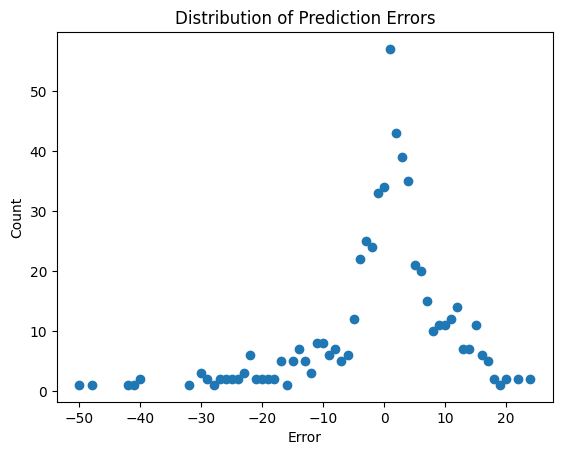

In [486]:
X_train_val_df = step4_dev_norm_df.copy()
# X_train_val_df = X_train_val_df

forest = RandomForestRegressor(n_estimators=300, n_jobs=5, random_state=341967, min_samples_leaf=4, min_samples_split=4)
# hist = HistGradientBoostingRegressor(random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

forest.fit(X_train, y_train)
# hist.fit(X_train, y_train)

y_pred = forest.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.224589931506381

In [491]:
another_forest = RandomForestRegressor(n_estimators=300, n_jobs=9, random_state=341967)
# another_forest = HistGradientBoostingRegressor(random_state=341967)
another_forest.fit(step4_dev_norm_df, ages_df)

y_eval_pred = another_forest.predict(step4_eval_norm_df.values)

# with open("results.csv", "w") as fout:
#     fout.write("Id,Predicted\n")
 
#     for id, y in enumerate(y_eval_pred):
#         fout.write(f"{id},{y}\n")

In [492]:
X_train_male, X_train_female = split_gender(step4_dev_norm_df)
ages_male, ages_female = split_ages(step4_dev_norm_df, ages_df)

reg_male, reg_female = gender_regs(X_train_male, X_train_female, ages_male, ages_female)

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,zcr_mean,spectral_centroid_mean,hnr,num_pauses,silence_duration,...,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy,char_per_second,words_per_second
4,1.205407,0.411146,-0.395821,1.032230,0.589336,0.048513,-0.424086,-0.151479,-0.099722,0.418993,...,1.883500,0.827822,-0.713329,-0.494132,0.417652,0.857947,0.187058,1.249804,1.309791,1.246033
6,1.447612,0.412951,-0.401807,0.131235,1.054533,1.412521,1.028673,-1.517644,1.161597,0.770379,...,-0.071766,-0.284148,-0.953797,-1.350599,-0.738357,-0.863501,1.223065,-1.130081,0.321190,0.280741
9,-1.103980,0.391362,0.271042,-0.521464,0.228935,-0.612130,-0.783906,0.714920,-0.800455,-1.113123,...,-0.486658,-1.214902,-0.736998,-1.345989,0.802475,-0.669937,-0.168308,0.162991,1.340269,1.033029
10,-0.189020,0.412310,-0.317283,0.060822,-0.193576,-0.468991,-0.610619,-0.254363,0.040424,0.373998,...,0.919114,0.613063,0.036254,-0.267500,0.093962,0.578506,-1.019051,-1.591387,1.047683,0.990105
11,0.343070,0.411526,-0.415021,-0.830892,-0.122503,0.702608,0.210056,-0.305166,0.040424,0.414707,...,-0.641777,-1.718479,-0.888634,0.471817,0.353483,0.383587,0.988856,-0.878316,0.881093,0.827443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,1.311620,0.413050,-0.364168,-0.202503,0.218898,1.591567,1.132996,-0.515314,0.671084,0.620397,...,-0.819244,-1.454942,-0.900420,-0.920417,0.229721,0.539436,0.632340,-0.322646,0.744140,0.693719
2924,-1.675496,-4.775648,0.493640,4.460926,2.175901,-1.583777,-2.564245,1.149475,-0.800455,-1.104716,...,-0.224498,-0.353751,0.170780,-0.620113,1.176474,1.224987,-0.986212,2.122272,-1.999671,-1.985396
2926,-1.451203,-0.997936,-0.072457,-0.893085,-1.165323,-1.096426,-0.235678,0.668177,-0.730382,-0.965125,...,-0.092078,-0.177741,-0.571117,-0.251799,0.989192,0.247347,0.059368,0.789164,-1.062069,-0.991179
2928,1.090528,0.412179,-0.410228,0.371027,0.262767,0.136031,0.021567,-0.686643,-0.099722,0.365428,...,0.111208,-0.515737,0.012804,-0.829266,-0.236687,0.487076,1.068771,-0.366509,1.098312,1.039541


,mean_pitch,max_pitch,min_pitch,jitter,shimmer,zcr_mean,spectral_centroid_mean,hnr,num_pauses,silence_duration,...,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy,char_per_second,words_per_second
0,1.526488,0.413221,-0.400362,-1.116336,-0.862609,2.039603,1.616870,-1.287020,1.862330,0.954642,...,-0.409284,-0.006544,0.290578,0.682363,-0.889873,-1.002949,1.472642,0.154252,-0.196683,-0.224921
1,0.261473,0.411611,-0.415793,0.627830,-0.396497,-0.502063,-0.843696,-0.322635,0.601010,0.543263,...,-0.328614,-0.102006,-0.812425,1.820217,0.244973,0.506093,-0.611328,2.142459,0.710397,0.660771
2,0.346071,0.411505,-0.402148,-0.320350,0.403982,0.011442,0.691972,-0.622378,-0.800455,0.751095,...,-0.119593,-0.470911,0.766201,0.064371,-0.206859,0.528806,0.182260,-1.389417,0.919251,0.864701
3,0.581502,0.410845,0.278367,-0.631887,-0.184536,1.334833,1.888962,0.469989,-0.239869,0.566836,...,-0.591112,1.658283,0.893509,3.596732,3.147535,1.426533,0.090276,-1.326892,0.814212,0.762139
5,0.166581,0.411576,-0.351001,0.672062,-0.474021,0.915270,0.301261,-0.492372,0.601010,0.562547,...,-0.583052,1.104148,-0.057343,2.771101,0.578794,0.412324,0.433208,-0.557365,0.366222,0.324712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,0.647983,0.411964,-0.393607,-0.895104,-0.684771,0.593196,-0.295984,-0.887256,0.390791,0.408280,...,-0.603309,0.062150,0.429960,2.225692,-0.547797,-0.119372,-0.106703,0.412755,0.641719,0.593713
2927,-0.162739,0.412164,-0.397469,0.884758,0.656932,0.138012,-0.544140,0.175654,-0.800455,1.512491,...,-0.481284,-0.601770,-0.934760,-0.059988,1.159927,1.418593,-0.422679,-0.740041,0.116549,0.080926
2929,-0.241320,0.384949,-0.359526,-0.886479,0.655138,-0.663606,0.925998,2.114540,-0.800455,-1.106545,...,0.614911,-0.003935,-0.589239,0.261712,-1.128330,-0.646004,0.417021,-0.411038,-1.999671,-1.985396
2930,-0.471048,0.393440,0.542899,-1.737977,-0.145028,-0.897263,0.124957,0.536230,-0.800455,-1.094012,...,-0.603494,1.823721,-0.865226,-1.164112,-0.850815,-1.651256,-0.198926,0.747164,-0.766782,-1.440673


10.784918004930935

In [493]:
X_eval_male, X_eval_female = split_gender(step4_eval_norm_df)

y_pred_male = reg_male.predict(X_eval_male)
y_pred_female = reg_female.predict(X_eval_female)

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,zcr_mean,spectral_centroid_mean,hnr,num_pauses,silence_duration,...,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy,char_per_second,words_per_second
0,-0.320241,0.310818,-0.411849,0.134684,2.184013,-1.390696,-1.082816,-1.096143,-0.730382,2.278922,...,2.806290,0.861915,1.246719,1.076342,-0.730406,0.583601,0.406775,1.116680,-0.355649,-0.380139
1,0.102166,0.412198,-0.364788,0.812343,0.856721,0.370281,0.291016,-0.096969,1.021450,1.486006,...,1.052991,0.252324,-0.019503,-0.299337,0.511421,1.102741,-0.552770,-1.371416,-0.013497,-0.046054
2,-0.558399,-0.627155,-0.335666,-0.474905,-0.394877,-0.302604,-0.409095,0.075326,-0.730382,-1.035831,...,-0.394942,-1.333958,-1.453149,-1.105715,0.374180,-0.506693,0.422998,-0.526640,0.060927,0.249288
4,1.072945,0.413308,-0.418335,0.065148,-0.133977,0.700578,0.618910,-1.570950,1.582037,0.823943,...,-0.348304,-0.341491,0.465986,-1.085457,-1.039645,-1.024911,1.432160,-0.126810,-0.084126,-0.115018
8,0.665934,0.413123,-0.410169,-0.123561,-0.646200,1.035174,0.553997,-1.052301,2.352843,0.961070,...,-0.575857,-0.604260,-0.518576,-1.007459,-0.370142,-0.470586,1.149402,0.202117,-0.242429,-0.269588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,-0.922506,-2.406507,-0.229033,-0.594231,0.428780,-1.065063,-0.138231,-0.197232,-0.800455,-1.018690,...,0.056844,-0.119635,1.570220,-0.181603,-0.931881,-2.132701,0.312401,1.527714,-1.999671,-1.985396
686,-1.494505,0.227313,-0.335126,-0.354417,-0.984281,-0.633110,-0.397127,0.822860,-0.800455,-1.073996,...,-0.636847,-0.084684,-1.042569,-0.383472,0.923756,0.503743,-0.407859,-1.276748,-0.330021,0.670308
687,-0.520128,0.261718,-0.274361,0.479719,0.336241,-0.539820,1.975118,-1.830235,-0.800455,-0.795860,...,1.025027,2.542368,1.501334,-0.713440,-1.478179,-4.301069,-0.256044,-0.911738,-0.997565,-0.717501
689,1.375527,0.412741,-0.363880,0.743982,-0.045242,0.710718,-0.067122,-0.495225,-0.169796,0.688960,...,0.221344,0.061082,-0.701233,-0.926189,0.128487,0.012906,1.978717,0.128856,0.922770,0.868137


,mean_pitch,max_pitch,min_pitch,jitter,shimmer,zcr_mean,spectral_centroid_mean,hnr,num_pauses,silence_duration,...,f1_var,f2_var,f3_var,f4_var,temporalMedian,temporal_entropy,frequence_entropy,mean_spectral_entropy,char_per_second,words_per_second
3,0.499864,0.411678,-0.405267,0.920924,-0.649645,-0.149515,-0.594843,-0.702563,1.301743,0.798232,...,0.234241,0.089626,0.589817,0.592588,0.127148,0.371224,-1.116525,0.088667,-0.003685,-0.036473
5,-0.352897,0.365670,1.540887,0.692656,0.036724,-0.944737,-0.752674,-0.284318,-0.800455,-1.012982,...,-0.396750,-0.238764,-0.627292,-0.943763,-1.052312,-1.820031,0.178587,3.430774,-1.106561,-1.275117
6,1.196686,0.412974,-0.337753,0.025134,-0.632157,0.890423,0.565992,-0.966506,1.091524,0.549691,...,-0.409339,-0.720751,1.065235,0.242094,-0.458766,0.113339,-0.910171,-0.853053,0.394543,0.352365
7,0.469450,0.364065,0.454869,-0.903139,-1.179053,-0.631689,-0.111111,0.739884,-0.730382,-1.063948,...,-0.203945,0.262517,-0.751192,-0.959486,1.013297,-0.330842,0.296661,2.537355,-0.361743,0.619852
11,-1.181101,-2.133234,0.429881,0.386844,-0.332872,-0.716123,0.125839,1.896079,-0.800455,-1.108449,...,1.520184,-0.980644,0.234778,-0.908891,-0.514131,1.244847,-1.013685,-1.123333,0.119736,0.422517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,0.123424,0.401404,0.256755,-0.819483,-1.212825,-0.856150,1.023562,1.983812,-0.800455,-1.076653,...,-0.327822,-0.847931,-0.998218,-0.886635,0.451851,1.390257,-0.922841,-0.565178,-0.278661,-0.518934
680,-0.159394,0.412416,-0.334628,0.565119,0.432907,-0.098468,-0.754312,-0.322530,-0.029649,0.814260,...,-0.363304,1.401468,1.113010,1.565823,0.000396,0.504169,0.617361,-0.220425,0.625290,0.577672
682,-0.083667,0.412597,-0.412905,-0.570448,-0.109651,-0.412748,-0.978844,-0.887577,1.722183,1.509575,...,-0.470002,-0.272645,0.259056,1.245425,-0.703632,-0.048094,0.044406,1.856340,-0.449235,-0.471518
683,-0.773398,-1.358641,-0.172122,-0.184494,1.713657,-0.636600,0.406052,0.421948,-0.800455,-0.980077,...,0.678176,-0.098949,-0.860691,0.518462,-1.044219,0.366329,-0.466039,0.359053,-0.512893,0.192740


In [494]:
y_eval_pred = merge_genders(y_pred_male, y_pred_female, X_eval_male.index, X_eval_female.index)

y_eval_pred = (y_eval_pred+another_forest.predict(step4_eval_norm_df))/2
with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")

9.675518577217927

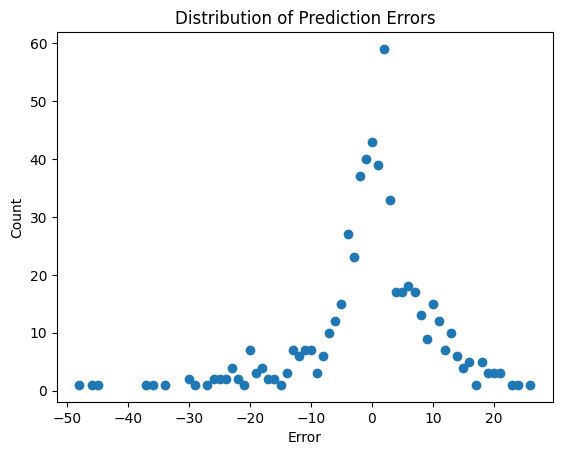

In [429]:
X_train_val_df = step4_dev_norm_df.copy()
# X_train_val_df = X_train_val_df.drop(columns=['age'], axis=1)

# forest = RandomForestRegressor(n_estimators=800, n_jobs=5, random_state=341967)
hist = HistGradientBoostingRegressor(random_state=341967, categorical_features=X_train_val_df.dtypes == 'object')

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

hist.fit(X_train, y_train)
y_pred = hist.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.224589931506381

In [316]:
imps = sorted(zip(forest.feature_names_in_, forest.feature_importances_), key=lambda x:x[1] , reverse=True)
imps

[('silence_duration', np.float64(0.41021086087705244)),
 ('hnr', np.float64(0.07675394529728276)),
 ('jitter', np.float64(0.07092571640264032)),
 ('spectral_centroid_mean', np.float64(0.06843420982599936)),
 ('shimmer', np.float64(0.06676246633908917)),
 ('mean_pitch', np.float64(0.0638081482837941)),
 ('num_pauses', np.float64(0.05950228380631497)),
 ('max_pitch', np.float64(0.05702632256726866)),
 ('zcr_mean', np.float64(0.05660639043618252)),
 ('min_pitch', np.float64(0.05245824520063335)),
 ('gender', np.float64(0.01751141096374226))]

In [162]:
print(sum([imp for f, imp in imps[:46]]))

drop_features = [f for f,imp in imps[46:]]
drop_features.remove('gender')
print(len(drop_features))
# drop_features.append('audio_length')
drop_features

0.9534172332459735
6


['f4_mean',
 'zcr_mean',
 'spectral_centroid_mean',
 'lowest_freq_in_spectrum',
 'spectrum_wide',
 'highest_freq_in_spectrum']

In [163]:
step4_dev_pruned_df = step4_dev_norm_df.drop(columns=drop_features, axis=1)
step4_eval_pruned_df = step4_eval_norm_df.drop(columns=drop_features, axis=1)

# step4_dev_pruned_df = step4_dev_norm_df.copy()
# step4_eval_pruned_df = step4_eval_norm_df.copy()

10.353441514419456

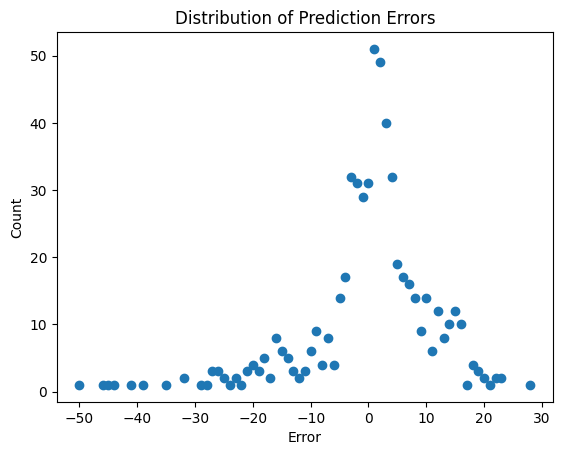

In [164]:
# let us try remove them
X_train_val_df = step4_dev_pruned_df.copy()
X_train_val_df = X_train_val_df

forest_pruned = RandomForestRegressor(n_estimators=300, n_jobs=5, random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

forest_pruned.fit(X_train, y_train)
y_pred = forest_pruned.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.186472864996084

In [165]:
y_eval_pred = forest_pruned.predict(step4_eval_pruned_df.values)

with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")

In [134]:
sorted(zip(forest_pruned.feature_names_in_, forest_pruned.feature_importances_), key=lambda x:x[1] , reverse=True)

[('silence_duration', np.float64(0.2626452094705673)),
 ('mfcc_frequency_mean_4', np.float64(0.03251407856446191)),
 ('pitch_iqr', np.float64(0.030674653791223624)),
 ('words_per_second', np.float64(0.03033143095456077)),
 ('mfcc_frequency_mean_0', np.float64(0.02917018872525495)),
 ('char_per_second', np.float64(0.027930400398648376)),
 ('min_pitch_pm', np.float64(0.02712013071913282)),
 ('mfcc_frequency_mean_7', np.float64(0.02697307635934908)),
 ('median_pitch_pm', np.float64(0.02374038916657775)),
 ('mean_pitch', np.float64(0.021730665581304633)),
 ('dominant_frequency', np.float64(0.020645570307955947)),
 ('mfcc_frequency_mean_9', np.float64(0.020245691385829472)),
 ('mfcc_frequency_mean_2', np.float64(0.019191275615173482)),
 ('hnr', np.float64(0.0183163873498651)),
 ('jitter', np.float64(0.01786582188277396)),
 ('mfcc_frequency_mean_12', np.float64(0.01762754067970893)),
 ('mfcc_frequency_mean_6', np.float64(0.017399822474666385)),
 ('mfcc_frequency_mean_8', np.float64(0.0166847

In [271]:
X_train_male, X_train_female = split_gender(step4_dev_norm_df)
ages_male, ages_female = split_ages(step4_dev_norm_df, ages_df)

reg_male, reg_female = gender_regs(X_train_male, X_train_female, ages_male, ages_female)

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_pauses,silence_duration,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,spect_frequency_mean_22,...,harmonic_frequency_mean_30,harmonic_frequency_mean_31,percussion_frequency_mean_0,percussion_frequency_mean_1,percussion_frequency_mean_2,percussion_frequency_mean_3,percussion_frequency_mean_4,percussion_frequency_mean_5,percussion_frequency_mean_6,percussion_frequency_mean_7,percussion_frequency_mean_8,percussion_frequency_mean_9,percussion_frequency_mean_10,percussion_frequency_mean_11,percussion_frequency_mean_12,percussion_frequency_mean_13,percussion_frequency_mean_14,percussion_frequency_mean_15,percussion_frequency_mean_16,percussion_frequency_mean_17,percussion_frequency_mean_18,percussion_frequency_mean_19,percussion_frequency_mean_20,percussion_frequency_mean_21,percussion_frequency_mean_22,percussion_frequency_mean_23,percussion_frequency_mean_24,percussion_frequency_mean_25,percussion_frequency_mean_26,percussion_frequency_mean_27,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,zcr,mean_coeffs,std_coeffs,fundamental_freq,char_per_second,words_per_second
4,1.096713,0.411146,-0.395821,1.093041,0.682511,0.474725,0.292051,-0.295562,-0.376805,-0.151479,-0.099722,0.418993,-0.582905,0.114856,-0.581158,0.190268,0.267847,0.597198,0.229116,-0.347467,-0.389014,0.008921,0.100869,0.667028,1.351876,1.310821,1.200526,0.668323,-0.059131,-0.518333,-0.494828,-0.332895,-0.191578,0.051954,0.443417,0.745608,0.657551,0.306650,-0.073895,-0.163395,...,-0.224269,-0.292482,0.111768,0.362287,0.459440,0.386954,0.508089,0.325428,0.172489,0.075548,0.133198,0.045616,-0.064218,-0.112897,-0.178566,-0.084650,0.065351,0.165087,0.213946,0.171898,0.113767,0.161388,0.203551,0.191176,0.122003,0.063019,0.021731,-0.033871,-0.071057,-0.086314,-0.073338,-0.049806,-0.035726,-0.045552,0.037653,0.575739,0.262986,-1.018814,1.312880,1.249290
6,1.248002,0.412951,-0.401807,0.285230,1.065699,-0.885193,1.224996,1.001083,-0.970233,-1.517644,1.161597,0.770379,-0.072279,0.008446,0.190131,-0.017345,-0.786494,-1.055750,-1.065655,-0.936462,-0.713446,-0.336950,-0.140071,-0.184657,0.065723,0.300195,0.206085,0.399635,0.332190,0.237901,0.159030,0.043610,-0.051640,-0.049755,0.044764,0.066257,-0.040720,-0.071098,0.030962,0.120683,...,-0.302310,-0.374134,0.468117,0.812909,0.713546,0.302653,0.043159,-0.008744,-0.135867,-0.122861,-0.011204,0.092973,0.062408,0.092167,0.117613,0.153989,0.170196,0.203765,0.306367,0.471341,0.495299,0.441189,0.388234,0.361403,0.310398,0.278157,0.252502,0.216765,0.183832,0.139841,0.128431,0.109013,0.029241,-0.080561,1.410955,-0.509318,-0.339413,-1.131255,0.320584,0.280246
9,-1.093927,0.391362,0.271042,-0.450725,0.356010,0.803222,-0.415347,-0.704939,-1.152218,0.714920,-0.800455,-1.113123,-0.515232,0.115526,-0.694175,0.206131,0.580728,1.134956,0.590419,0.277670,0.320352,0.590270,0.097350,0.197371,0.144416,-0.141925,0.374563,0.749175,0.489085,0.205465,0.077221,-0.096193,-0.158708,-0.279170,-0.398674,-0.442040,-0.482371,-0.502810,-0.475362,-0.431052,...,0.303186,-0.168944,0.248263,0.702724,1.410602,2.102506,2.175960,1.701368,1.217260,1.043151,0.882195,1.718888,2.330646,1.474024,0.379370,-0.143657,-0.370164,-0.288801,-0.193968,-0.036985,0.076334,0.059478,-0.007467,-0.019840,-0.019554,0.062483,0.157843,0.161718,0.150359,0.096751,0.0185

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_pauses,silence_duration,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,spect_frequency_mean_22,...,harmonic_frequency_mean_30,harmonic_frequency_mean_31,percussion_frequency_mean_0,percussion_frequency_mean_1,percussion_frequency_mean_2,percussion_frequency_mean_3,percussion_frequency_mean_4,percussion_frequency_mean_5,percussion_frequency_mean_6,percussion_frequency_mean_7,percussion_frequency_mean_8,percussion_frequency_mean_9,percussion_frequency_mean_10,percussion_frequency_mean_11,percussion_frequency_mean_12,percussion_frequency_mean_13,percussion_frequency_mean_14,percussion_frequency_mean_15,percussion_frequency_mean_16,percussion_frequency_mean_17,percussion_frequency_mean_18,percussion_frequency_mean_19,percussion_frequency_mean_20,percussion_frequency_mean_21,percussion_frequency_mean_22,percussion_frequency_mean_23,percussion_frequency_mean_24,percussion_frequency_mean_25,percussion_frequency_mean_26,percussion_frequency_mean_27,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,zcr,mean_coeffs,std_coeffs,fundamental_freq,char_per_second,words_per_second
0,1.295444,0.413221,-0.400362,-1.298379,-0.853814,-0.404445,1.534388,1.416622,0.796088,-1.287020,1.862330,0.954642,1.327894,-0.301255,2.435581,-0.621678,-0.597478,-1.242956,-0.987757,-0.424440,0.527754,0.887412,0.404501,0.230277,0.420465,0.690253,0.431868,0.017823,0.086242,0.079350,-0.285810,-0.586816,-0.681605,-0.625618,-0.497324,-0.429895,-0.348431,-0.157438,0.080994,0.115811,...,-0.329154,-0.351707,0.978197,0.980590,0.539739,0.296976,0.311208,0.074792,0.118172,0.153783,0.111857,0.155441,0.187506,0.105655,-0.069616,-0.260302,-0.410468,-0.579481,-0.646734,-0.611466,-0.487242,-0.377889,-0.326924,-0.353408,-0.349771,-0.326964,-0.263849,-0.204255,-0.141510,-0.091011,-0.058179,-0.088360,-0.153126,-0.225357,2.039962,-0.678260,0.003154,1.126899,-0.197371,-0.225573
1,0.406357,0.411611,-0.415793,0.754143,-0.288687,0.855523,-0.277067,-0.777731,0.121675,-0.322635,0.601010,0.543263,-0.109528,0.027451,0.052437,0.019728,0.562547,0.905155,0.789437,0.561367,0.647430,0.313440,0.565612,0.630925,0.806721,0.710418,-0.059090,-0.363712,-0.265302,-0.002396,-0.080268,-0.365787,-0.565798,-0.723426,-0.725798,-0.705868,-0.660981,-0.613170,-0.588894,-0.566910,...,-0.350050,-0.361253,0.060830,0.441999,0.521555,0.805936,1.008057,0.843677,0.839530,0.575269,0.434254,0.049028,-0.217937,-0.109264,-0.060968,-0.071022,-0.185749,-0.419093,-0.567990,-0.614885,-0.607557,-0.572708,-0.547415,-0.556360,-0.572857,-0.576756,-0.570614,-0.571207,-0.565445,-0.550520,-0.540773,-0.520799,-0.475700,-0.450814,-0.517137,0.566580,0.813061,0.654294,0.710913,0.661428
2,0.476199,0.411505,-0.402148,-0.206386,0.518159,-0.123477,0.258771,0.739585,-0.225751,-0.622378,-0.800455,0.751095,-0.776157,0.117258,-0.598683,0.194970,-0.179217,-0.047052,-0.247578,-0.417702,-0.453974,-0.090468,0.035952,-0.354046,-0.445564,-0.047697,0.171123,-0.107342,-0.229280,-0.288128,-0.206941,-0.146881,-0.087851,0.193343,0.425399,0.464089,0.267721,0.311953,0.395230,0.337627,...,0.193246,0.042198,-0.447319,-0.275886,-0.022262,0.079994,-0.205221,-0.249251,-0.282268,-0.320338,-0.122745,-0.086239,-0.028237,-0.033572,-0.053769,-0.064480,-0.056498,-0.037569,-0.032997,0.019845,0.155596,0.320530,0.377715,0.408559,0.393956,0.417690,

10.922874220107058

# Upload section

In [272]:
# y_eval_pred = forest_pruned.predict(step4_eval_pruned_df)
X_eval_male, X_eval_female = split_gender(step4_eval_norm_df)

y_eval_pred_male = reg_male.predict(X_eval_male)
y_eval_pred_female = reg_female.predict(X_eval_female)

y_eval_pred = merge_genders(y_eval_pred_male, y_eval_pred_female, index_male=X_eval_male.index, index_female=X_eval_female.index)
display(y_eval_pred)

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_pauses,silence_duration,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,spect_frequency_mean_22,...,harmonic_frequency_mean_30,harmonic_frequency_mean_31,percussion_frequency_mean_0,percussion_frequency_mean_1,percussion_frequency_mean_2,percussion_frequency_mean_3,percussion_frequency_mean_4,percussion_frequency_mean_5,percussion_frequency_mean_6,percussion_frequency_mean_7,percussion_frequency_mean_8,percussion_frequency_mean_9,percussion_frequency_mean_10,percussion_frequency_mean_11,percussion_frequency_mean_12,percussion_frequency_mean_13,percussion_frequency_mean_14,percussion_frequency_mean_15,percussion_frequency_mean_16,percussion_frequency_mean_17,percussion_frequency_mean_18,percussion_frequency_mean_19,percussion_frequency_mean_20,percussion_frequency_mean_21,percussion_frequency_mean_22,percussion_frequency_mean_23,percussion_frequency_mean_24,percussion_frequency_mean_25,percussion_frequency_mean_26,percussion_frequency_mean_27,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,zcr,mean_coeffs,std_coeffs,fundamental_freq,char_per_second,words_per_second
0,-19.186828,-7.093777,-39.216378,15.394010,24.438343,5.606421,-3.622150,-36.389369,-3.738796,1.910239,-0.921709,-1.035520,-0.822620,0.008801,0.187367,-0.016626,-0.174548,0.306593,-0.075705,-0.406809,-0.135741,-0.084396,-0.035119,-0.059031,-0.032868,0.237248,0.209990,-0.183895,-0.354216,-0.515302,-0.659096,-0.688095,-0.660717,-0.576809,-0.502914,-0.472247,-0.444524,-0.409305,-0.343552,-0.341683,...,-0.640532,-0.543987,-0.185335,-0.318359,-0.157713,-0.177654,-0.178255,-0.174851,-0.207242,-0.136601,-0.156807,-0.218603,-0.244587,-0.318127,-0.388977,-0.487427,-0.549298,-0.523380,-0.377896,-0.297790,-0.319931,-0.373496,-0.419620,-0.484799,-0.548979,-0.570178,-0.566551,-0.566751,-0.584624,-0.629155,-0.671135,-0.701837,-0.741841,-0.761459,-1.411764,-0.353486,-0.141627,-0.144316,-1.993820,-1.965106
1,-16.762242,-7.093587,-39.203853,20.243094,16.255260,7.429258,6.794064,-24.119654,-3.731487,1.936231,-0.798952,-1.108686,0.204179,0.130162,-0.692508,0.220186,0.648044,0.916194,0.665016,-0.019018,-0.390697,-0.088333,-0.107092,-0.103065,0.226158,0.041955,-0.186879,0.244199,0.407574,0.542665,0.928316,1.113102,1.061620,0.821135,0.391095,0.233833,0.282940,0.566148,0.808200,0.925782,...,0.009349,-0.355657,-0.239910,-0.200064,-0.094307,0.099648,0.099749,0.112363,0.029732,0.053911,0.198346,0.167888,0.340523,0.626411,0.761247,0.954344,0.972975,1.021883,0.983243,0.953278,0.883255,0.992508,1.043888,1.091266,1.069715,1.087281,1.067375,1.132725,1.161715,1.258337,1.261741,1.222386,0.910574,0.471550,0.361356,0.343629,0.335688,-0.647425,-1.992790,-1.961008
2,-20.737616,-7.095538,-39.196102,10.102150,5.985827,6.448321,4.204857,-29.740139,-3.701787,1.940714,-0.921709,-1.341386,-0.393298,0.117136,-0.694175,0.207701,0.212112,0.215721,0.021599,-0.038289,0.561884,0.823539,0.470644,0.431693,0.490027,-0.026955,-0.352435,-0.230219,-0.245562,-0.397959,-0.054892,0.354140,0.470382,0.200646,0.265534,0.514598,0.297686,0.146191,0.154582,0.189395,...,-0.143801,-0.260716,0.161545,0.236136,0.342682,0.732690,0.736434,0.658430,0.699027,0.495549,0.354725,0.164375,0.299043,0.367821,0.268639,0.570086,0.516636,0.358934,0.230022,0.290121,0.286561,0.376612,0.521097,0.531748,0.480405,0.499225,0.36

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_pauses,silence_duration,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_frequency_mean_0,spect_frequency_mean_1,spect_frequency_mean_2,spect_frequency_mean_3,spect_frequency_mean_4,spect_frequency_mean_5,spect_frequency_mean_6,spect_frequency_mean_7,spect_frequency_mean_8,spect_frequency_mean_9,spect_frequency_mean_10,spect_frequency_mean_11,spect_frequency_mean_12,spect_frequency_mean_13,spect_frequency_mean_14,spect_frequency_mean_15,spect_frequency_mean_16,spect_frequency_mean_17,spect_frequency_mean_18,spect_frequency_mean_19,spect_frequency_mean_20,spect_frequency_mean_21,spect_frequency_mean_22,...,harmonic_frequency_mean_30,harmonic_frequency_mean_31,percussion_frequency_mean_0,percussion_frequency_mean_1,percussion_frequency_mean_2,percussion_frequency_mean_3,percussion_frequency_mean_4,percussion_frequency_mean_5,percussion_frequency_mean_6,percussion_frequency_mean_7,percussion_frequency_mean_8,percussion_frequency_mean_9,percussion_frequency_mean_10,percussion_frequency_mean_11,percussion_frequency_mean_12,percussion_frequency_mean_13,percussion_frequency_mean_14,percussion_frequency_mean_15,percussion_frequency_mean_16,percussion_frequency_mean_17,percussion_frequency_mean_18,percussion_frequency_mean_19,percussion_frequency_mean_20,percussion_frequency_mean_21,percussion_frequency_mean_22,percussion_frequency_mean_23,percussion_frequency_mean_24,percussion_frequency_mean_25,percussion_frequency_mean_26,percussion_frequency_mean_27,percussion_frequency_mean_28,percussion_frequency_mean_29,percussion_frequency_mean_30,percussion_frequency_mean_31,zcr,mean_coeffs,std_coeffs,fundamental_freq,char_per_second,words_per_second
3,-14.775719,-7.093588,-39.214626,20.942970,3.422789,9.287145,4.873228,-31.429445,-3.701787,1.920477,-0.779311,-1.172149,-0.371964,-0.156830,1.388428,-0.339852,1.052848,2.011071,1.585917,0.543093,-0.205579,0.160347,0.344253,0.325834,0.451156,0.406064,-0.099631,0.027461,0.259128,0.117556,-0.067799,-0.089979,-0.069089,-0.325604,-0.454618,-0.438112,-0.394419,-0.319118,-0.351168,-0.387503,...,-0.333604,-0.371648,-0.047893,0.147634,0.445611,0.536061,0.344239,0.378605,0.316015,0.284959,0.245400,0.045206,-0.073860,-0.061928,-0.228482,-0.374794,-0.373398,-0.341554,-0.280736,-0.241146,-0.197022,-0.173131,-0.167287,-0.187071,-0.236268,-0.278445,-0.304912,-0.317609,-0.327829,-0.329503,-0.318519,-0.303663,-0.290454,-0.315288,-0.161951,1.087977,1.406863,-0.416097,-1.992764,-1.960905
5,-19.390695,-7.093674,-38.696657,19.449329,9.909256,2.850339,0.545802,-32.944686,-3.690455,1.931358,-0.926619,-1.339277,0.344027,0.008517,-0.694175,0.101721,-0.862236,-0.951377,-0.931892,-0.909496,-0.703617,-0.211819,0.179086,0.697406,0.506086,-0.312053,-0.461901,-0.076960,0.333284,0.447625,0.191777,-0.378606,-0.793347,-0.886275,-0.881055,-0.862809,-0.846717,-0.826363,-0.774884,-0.701822,...,-0.516041,-0.471899,0.165638,0.129759,0.351811,0.243714,-0.222382,-0.147009,-0.081508,-0.101437,-0.230774,-0.192066,0.101829,0.229361,0.034582,-0.327732,-0.511667,-0.767236,-0.925006,-1.008286,-1.019297,-0.992276,-0.948147,-0.873639,-0.825729,-0.801455,-0.769187,-0.749393,-0.734894,-0.727308,-0.718554,-0.717425,-0.698078,-0.690705,-0.953722,-1.000569,-0.970960,1.647216,-2.104018,-2.410029
6,-11.802188,-7.093586,-39.196657,14.518413,3.605422,6.743634,8.337665,-22.174231,-3.676455,1.913611,-0.794042,-1.195083,0.122738,-0.015906,0.366725,-0.064868,-0.038833,-0.237250,0.124633,0.216286,-0.024739,0.373084,0.231602,-0.137051,-0.155562,-0.098373,-0.160326,-0.204779,-0.168288,-0.122246,-0.108449,-0.020425,-0.074847,-0.213017,-0.256405,-0.145875,-0.078921,-0.093414,-0.251225,-0.281559,...,-0.311947,-0.287820,-0.026571,-0.067489,-0.162780,-0.101452,0.027754,-0.193753,-0.159972,-0.128728,-0.092923,-0.138262,-0.137876,-0.135791,-0.163718,-0.121235,-0.085007,-0.052775,-0.028269,0.008732,-0.007591,0.00

0      28.87
1      24.74
2      21.95
3      22.92
4      26.92
       ...  
686    21.38
687    23.95
688    23.40
689    32.75
690    20.56
Length: 691, dtype: float64

In [274]:
with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")